In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import os, pickle
from pose_class import Trajectory
import pdb
import pandas as pd

import random
from scipy.stats.kde import gaussian_kde
from scipy.stats import norm
from scipy.stats import gamma
from scipy.stats import pearsonr,spearmanr
from scipy.stats import f_oneway,levene
from scipy.stats import ttest_ind
from scipy.stats import norm

from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')
print('ready set go!')

ready set go!


In [ ]:
## Define little function to get confidence intervals for pearson correlation
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    yanked from https://zhiyzuo.github.io/Pearson-Correlation-CI-in-Python/ with minor edits
    '''

    r, p = pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    n - len(x)
    return r, p, lo, hi, n

In [2]:
### My python environment was taking too long to solve, so lmer stats are done seperately
## I could probably put this together into a manuscript environment later...

## What this means is I need to save some pandas databases and run it in a seperate script

## Load Data

Data is a series of Sequence objects (generated by poseclass) and a bunch of playback data

In [3]:
## Make this False if you just want to make the figures and don't want a bunch of extra text
verbose = False

In [340]:
## Load the hand annotated info on postures
#test_3 = pd.read_csv('/data/birds/postures/presentation_info5.csv',delimiter=',')
test_3 = pd.read_csv('./DataManuscript/presentation_info.csv',delimiter=',')

song_list = ['BDY','BOD','ND','LB','2M','DBR','GRG','WG','LNR','DMG']
#song_list.extend(['BDY-','BOD-','LB-','DMG-']) ## Curtailed songs excluded for now
bird_list = ['CB-White','CB-Orange','CB-Yellow','CB-Red','CB-LB2','CB-Y2','CB-R2'] #2019 Birds
bird_list.extend(['P1','Y1','PINK2']) ## 2018 Birds
song_dict = dict(zip(song_list,range(10)))
bird_dict = dict(zip(bird_list,range(len(bird_list))))

duration_dict = {}
duration_list0 = []
latency_dict = {}
latency_list0 = []

seq_dir = './SeqClasses/'
bird_duration_dict = dict(zip(bird_list,[[] for x in range(len(bird_list))]))
bird_latency_dict = dict(zip(bird_list,[[] for x in range(len(bird_list))]))


for index,row in test_3.iterrows():
    if '2019' not in row['SeqName'] and '2018' not in row['SeqName']:
        if verbose:
            print('skipping',row['SeqName'])
        continue 
    try:
        s = row['SeqName']
        seq = pickle.load(open(seq_dir + s + '.obj','rb'))
        bird = row['Bird']
    except:
        if verbose:
            print(row['SeqName'],'is missing')
        s = row['SeqName']
        bird = row['Bird']
        seq = 0
    if bird not in bird_list:
        if verbose:
            print('skipping all',bird)
        continue
    if row['Song'] not in song_list:
        song = row['SeqName'].split('_')[-1]
        if song in song_list:
            test_3.at[index,'Song'] = song
        else:
            continue
    else:
        song=row['Song']
    if not pd.isnull(row['PostureDuration']):
        if song not in duration_dict.keys():
            duration_dict[song] = []
        if row['PostureDuration'] == 'R':
            continue
        seq_duration = float(row['PostureDuration'])
        #test_3.at[index,'Duration by My Method'] = seq_duration
        duration_dict[song].append(seq_duration)
        duration_list0.append(seq_duration)
        bird_duration_dict[bird].append(seq_duration)
        
    ## If we have both latency and offset info, store it

    if not pd.isnull(row['PostureStamp']) and seq != 0:
        if song not in latency_dict.keys():
            latency_dict[song] = []
        seq_latency = float(row['PostureStamp']) + seq.ts[0]
        if seq.ts[0] == 0:
            #print('unknown offset...')
            #print(row['SeqName'])
            #print(seq_latency)
            seq_latency = np.nan
            continue
        test_3.at[index, 'Latency minus offset'] = seq_latency

        latency_dict[song].append(seq_latency)
        latency_list0.append(seq_latency)
        bird_latency_dict[bird].append(seq_latency)
                                       
print('Done!')

Done!


In [5]:
## Define a little meta package for playback arrays

class Playback_meta():
    def __init__(self,n_birds,n_songs,n_blocks,bird_list,bird_dict,song_list,song_dict,name):
        self.n_birds = n_birds
        self.n_songs = n_songs
        self.n_blocks = n_blocks
        self.bird_list = bird_list
        self.bird_dict = bird_dict
        self.song_list = song_list
        self.song_dict = song_dict
        self.name = name
    
    def read_me(self):
        print('Reaout for group:',self.name)
        print('n_birds:',self.n_birds)
        print('n_songs:',self.n_songs)
        print('n_blocks:',self.n_blocks)
        print('birds:',self.bird_list)
        print('songs:',self.song_list)
 

In [342]:
## Import and process sequence data: [Bird, Block, Song, [Posture,Latency,Duration,Movement]]
## This originally built birdview_array

n_birds = len(bird_list)
data_array = np.empty([n_birds,20,10,4])
data_key = np.empty([n_birds,20,10,3],dtype=object)
data_array.fill(np.nan)

count = 0 
t_count = 0
p_count = 0
good_list = sorted(os.listdir('./SeqClasses/'))

#file_list = sorted(os.listdir('./SeqClasses/'))
file_lists = [good_list]
dir_list = ['./SeqClasses/']

for f in range(1): ## Originally I had multiple directories
    file_list = file_lists[f]
    seq_dir = dir_list[f]
    for s in file_list:

        seq = pickle.load(open(seq_dir + s,'rb'))
        if '2019' not in seq.seq_name and '2018' not in seq.seq_name:
            #print('still skipping 2018 for now')
            continue
        if seq.clean == False:
            if verbose:
                print('**Dirty rotten floor posture, still going to try my best')
            else:
                pass
        try:
            block = seq.block
            if block > 19:
                if verbose:
                    print(block,seq.machine)
                    print('block out of range,moving on')
                continue

        except:
            print(seq.seq_name,'has no block somehow...')
            import pdb
            pdb.set_trace()
        if block < 0:
            try: 
                manual_block = manual_row['Block'].item()
                if ~np.isnan(manual_block):
                    block = int(manual_block)
                    if block < 0:
                        if verbose:
                            print('negative block, moving on')
                        continue
                else:
                    if verbose:
                        print('negative block, moving on')
                    continue
            except:
                if verbose:
                    print('negative block, moving on')
                continue
        #if seq.bird == 'Y1':
            #print(seq.seq_name,seq.bird,seq.posture)
        if seq.bird=='no bird' or seq.bird=='males':
            continue
        if seq.bird=='unknown' or seq.song == 'unknown':
            continue
        try:
            if seq.bird == 'CB0':
                seq.bird = 'Y1'
            song_index = song_dict[seq.song]
            bird_index = bird_dict[seq.bird]
        except:
            if verbose:
                print(seq.seq_name,'broke something! moving on',seq.song,seq.bird)
            continue
        try:
            manual_row = test_3[test_3['SeqName'] == seq.seq_name]
            manual_posture = manual_row['Posture'].item()
            #print(manual_posture)
            if not pd.isna(manual_posture):
                posture_value = int(manual_posture)
            else:
                posture_value = seq.posture
            data_array[bird_index,int(block),song_index,0] = posture_value
            if verbose:
                print(seq.bird,seq.seq_name,bird_index,posture_value,'posture value stored')
        except:
            import pdb
            pdb.set_trace()
            print('posture failed for',seq.seq_name)

        try:
            data_key[bird_index,int(block),song_index,0] = seq.seq_name
            data_key[bird_index,int(block),song_index,1] = seq.machine
            data_key[bird_index,int(block),song_index,2] = 1 ## This means it doesn't suck
            if 'Crap' in seq_dir:
                data_key[bird_index,int(block),song_index,2] = 0  ## This means it sucks
        except:
            if verbose:
                print("Something Failed!")

        try:
            if seq.ts[0] == 0:
                ## No timing data, grab a likely 5s 
                response_window = (seq.ts > 5) & (seq.ts < 10)
            else:
                response_window = (seq.ts > 0) & (seq.ts < 5)
            ## A bunch of them have a mismatch between ts and data. I need to fix this
            if len(response_window) != len(seq.data):
                #print('data mismatch :(')
                if len(response_window) > len(seq.data):
                    #print('fixing it...')
                    response_window = response_window[:len(seq.data)]
                elif len(response_window) < len(seq.data):
                    print('we are in trouble.')
                    pdb.set_trace()
            movement = np.sum(abs(seq.smooth_data[response_window]))
            data_array[bird_index,int(block),song_index,3] = movement
            #print('added posture')
            p_count +=1
        except:
            #pdb.set_trace()
            if verbose:
                print('Movement failed...')
            movement = np.nan
            pass
        try:
            if seq.ts[0] != 0:
                manual_latency = manual_row['PostureStamp'].item() + seq.ts[0]
            else:
                manual_latency = np.nan
            manual_duration = manual_row['PostureDuration'].item()

            if not pd.isna(manual_latency):
                latency_value = float(manual_latency)
            else:
                latency_value = seq.t_vmax
            if not pd.isna(manual_duration):
                duration_value = float(manual_duration)
            else:
                duration_value = seq.duration
            t_count += 1
        except:
            if verbose:
                print('no timing information for',seq.seq_name)
            latency_value = np.nan
            duration_value = np.nan
            
        #print(seq.seq_name,posture_value,latency_value,duration_value,movement)
        #print(manual_latency)
        data_array[bird_index,int(block),song_index] = [posture_value,latency_value,duration_value,movement]
            #print('Found a posture : ',seq.seq_name,seq.posture)
        if seq.seq_name == '2018-05-26-14-18-03':
            pass
        if seq.bird == 'P1':
            print(seq.seq_name,posture_value,latency_value)
            #pdb.set_trace()

## Read through the playback log and if the seq is missing add the value
for i,row in test_3.iterrows():
    if '2019' not in row['SeqName'] and '2018' not in row['SeqName']:
        continue
    seq_name = row['SeqName'] + '.obj'
    if seq_name in os.listdir('./SeqClasses/'):
        # I already did this one, move on
        continue
    if row['Bird'] in bird_list and row['Song'] in song_list:
        #print(row)
        song_index = song_dict[row['Song']]
        bird_index = bird_dict[row['Bird']]
        block = row['Block']
        if np.isnan(data_array[bird_index,int(block),song_index][0]) and ~np.isnan(row['Posture']):
            data_array[bird_index,int(block),song_index][0] = row['Posture']
            data_array[bird_index,int(block),song_index][2] = row['PostureDuration']
            p_count += 1
            
birdview_array = data_array[:,:,:,:3]
birdview_meta = Playback_meta(data_array.shape[0],data_array.shape[2],data_array.shape[1],
                          bird_list,bird_dict,song_list,song_dict,'Birdview')
birdview_binary = np.copy(birdview_array)
#print('unique values',np.unique(birdview_binary[:,:,:,0]))
birdview_binary[:,:,:,0][birdview_binary[:,:,:,0] == 2] = 0
#print('binary values',np.unique(birdview_binary[:,:,:,0]))
print('Postures counted:',p_count)
print('Posture with timing info:',t_count)    

## Split data array into two smaller arrays
bv2019_dict = {}
bv2018_dict = {}
for b in bird_list[:7]:
    bv2019_dict[b] = bird_dict[b]
for b in bird_list[7:]:
    bv2018_dict[b] = bird_dict[b] - 7
    
bv2019_array = data_array[:7,:,:,:3]
bv2019_meta = Playback_meta(bv2019_array.shape[0],bv2019_array.shape[2],bv2019_array.shape[1],
                          bird_list[:7],bv2019_dict,song_list,song_dict,'Birdview19')
bv2019_binary = birdview_binary[:7]

bv2018_array = data_array[7:,:,:,:3]
bv2018_meta = Playback_meta(bv2018_array.shape[0],bv2018_array.shape[2],bv2018_array.shape[1],
                          bird_list[7:],bv2018_dict,song_list,song_dict,'Birdview18')
bv2018_binary = birdview_binary[7:]

2018-05-16-15-47-58 1 0.9239999294281006
2018-05-23-11-18-00 1 1.060999870300293
2018-05-23-12-48-02 1 0.9499999160766599
2018-05-24-11-46-16 1 1.1830001945495603
2018-05-24-15-48-01 1 0.9410002346038819
2018-05-26-08-17-58 1 1.0809997196197516
2018-05-26-14-18-03 1 0.9309999580383304
2018-05-28-08-18-02 1 1.5749998207092286
2018-05-28-14-18-02 0 nan
Postures counted: 636
Posture with timing info: 261


In [343]:
## Reshape Birdview 3 data into similar array
## What if I drop the lesioned birds? 

group1_file = './DataManuscript/2019_playbacks_1.csv'
group2_file = './DataManuscript/2019_playbacks_2.csv'

group1_df = pd.read_csv(group1_file)
group2_df = pd.read_csv(group2_file)

group1_df = group1_df.fillna(0)
group2_df = group2_df.fillna(0)

p_array1 = np.array(group1_df.iloc[:,6:15])
p_array2 = np.array(group2_df.iloc[:,6:15])

group1_list = list(group1_df.columns[6:15])
group2_list = list(group2_df.columns[6:15])
bird_list3 = []
bird_list3.extend(group1_list)
bird_list3.extend(group2_list)

print(bird_list3)
## [Bird, Block, Song, [Posture,Latency,Duration]]
bv3_array = np.empty([18,11,10,3])
bv3_array.fill(np.nan)

group1_dates = group1_df
# for each song
for s in range(10):
    song_name = song_list[s] + '.wav'
    #print(s,song_name)
    bv3_array[:9,:,s,0] = np.transpose(group1_df.loc[group1_df['SongFile'] == song_name].iloc[:,6:15])
    bv3_array[9:,:,s,0] = np.transpose(group2_df.loc[group2_df['SongFile'] == song_name].iloc[:,6:15])

sham_birds = [0,3,5,6,10,12,14,16]   
sham_list = [bird_list3[i] for i in sham_birds]

binary_array3 = np.array(bv3_array)
binary_array3[binary_array3 == .5] = 0

## Remove lesioned birds
if True:
    bv3_array = bv3_array[sham_birds]
    bird_list3 = sham_list
    binary_array3 = binary_array3[sham_birds]
    
bv3_array[:,:,:,0][bv3_array[:,:,:,0] == .5] = 2

bv3_meta = Playback_meta(len(bird_list3),10,11,bird_list3,dict(zip(bird_list3,range(len(bird_list3)))),song_list,song_dict,'Birdracks')
print(np.shape(binary_array3))

['WH20', 'WH18', 'WH13', 'Wh14', 'WH17', 'GR11', 'WH15', 'WH23', 'WH12 (22)', 'BK24', 'WH19', 'WH16', 'WH24', 'BK21', 'LB20', 'BK17', 'GR13', 'WH22']
(8, 11, 10, 3)


In [344]:
## Deal with David's playback data: dave_array07,meta_d07 

skips = 0
def parse_dave_data(playback_df,name='?',plot_me=False,sort_me=True,add_song = 0):
    song_list = pd.unique(playback_df[3])
    bird_list = pd.unique(playback_df[4])
    n_songs = len(song_list)
    if add_song is not 0:
        n_songs = n_songs + add_song
        song_list = np.append(song_list,'?')
    n_birds = len(bird_list)
    last_block = np.max(pd.unique(playback_df[0]))
    n_blocks = (last_block + n_songs - 1) // n_songs +1
    song_dict = dict(zip(song_list,range(n_songs)))
    bird_dict = dict(zip(bird_list,range(n_birds)))

    playback_array = np.zeros([n_birds,n_blocks,n_songs,3])

    for i,row in playback_df.iterrows():
        bird_index = bird_dict[row[4]]
        song_index = song_dict[row[3]]
        block_index = (row[0] - 1) // n_songs
        if playback_array[bird_index,block_index,song_index,0] != 0:
            #print(playback_array[bird_index,song_index,block_index],(bird_index,song_index,block_index))
            #print('I already did this one!',row[0])
            global skips
            skips += 1 

        if row[5].upper() == 'R':
            playback_array[bird_index,block_index,song_index,0] = 2 # label as partial
            playback_array[bird_index,block_index,song_index,2] = 0 # remove old durations
            
        else:
            playback_array[bird_index,block_index,song_index,0] = 1 # label as posture
            playback_array[bird_index,block_index,song_index,2] = int(row[5]) #set duration


  
    reorder = np.argsort(np.mean(playback_array[:,:,:,0],axis=(0,2)))[::-1]
    if sort_me:
        playback_array = playback_array[:,reorder]
    
    if plot_me:
        fig,ax = plt.subplots()
        ax.imshow(np.mean(playback_array[:,:,:,0],0),cmap='viridis',vmax=1)
        ax.set_xlabel('Blocks')
        ax.set_ylabel('Song id')
        fig.show()
    meta_data = Playback_meta(n_birds,n_songs,n_blocks,bird_list,bird_dict,song_list,song_dict,name)
    return playback_array,meta_data

playbacks07 = './DataManuscript/PB2007.txt'
playbacks09 = './DataManuscript/PB2009.txt'
playbacks10 = './DataManuscript/PB2010.txt'
playbacks11 = './DataManuscript/PB2011.txt'

dave_df07 = pd.read_csv(playbacks07,delimiter=',',header=None)
dave_df09 = pd.read_csv(playbacks09,delimiter=',',header=None)
dave_df10 = pd.read_csv(playbacks10,delimiter=',',header=None)
dave_df11 = pd.read_csv(playbacks11,delimiter=',',header=None)

dave_array07,meta_d07 = parse_dave_data(dave_df07,name='Dave_07',plot_me=False)
dave_array09,meta_d09 = parse_dave_data(dave_df09,name='Dave_09',plot_me=False)
dave_array10,meta_d10 = parse_dave_data(dave_df10,name='Dave_10',plot_me=False)
dave_array11,meta_d11 = parse_dave_data(dave_df11,name='Dave_11',plot_me=False)
print('total skips=',skips)

daviaries = [dave_array07,dave_array09,dave_array10,dave_array11]
dmetas = [meta_d07,meta_d09,meta_d10,meta_d11]

all_aviaries = [bv2018_array,bv2019_array,bv3_array,dave_array07,dave_array09,dave_array10,dave_array11]
all_metas = [bv2018_meta,bv2019_meta,bv3_meta, meta_d07,meta_d09,meta_d10,meta_d11]

all_binary = []

## For some reason, doing np.array(a) here breaks everything...
for a in all_aviaries:
    binary_a = np.copy(a)
    binary_a[:,:,:,0][binary_a[:,:,:,0] == 2] = 0
    all_binary.append(binary_a)

total skips= 24


In [628]:
## Load in hand labeled latencies from spread sheet 
# I decided calculating poo latency was too much work for now, but if I ever do it, the framework is here
test_3.infer_objects()
bird_list = birdview_meta.bird_list
song_list = birdview_meta.song_list
bird_dict = birdview_meta.bird_dict
song_dict = birdview_meta.song_dict
startle_latencies = []
look_latencies = []
depuff_latencies = []
depuff_birds,depuff_songs = [],[]
wingstroke_latencies = []
wingstroke_birds,wingstroke_songs = [],[]
leg_latencies = []
poo_latencies = []
csd_latencies,csd_offsets = [],[]
partial_latencies,partial_offsets = [],[]
s_count,d_count,w_count,c_count,p_count,l_count,g_count,o_count,poo_count = 0,0,0,0,0,0,0,0,0
total_count,other_count = 0,0
chi_counts = {
    'CSD/WS':0,
    'CSD/DP':0,
    'WS/DP':0,
    'PSD/WS':0,
    'PSD/DP':0
}

bird_count_dict = dict(zip(bird_list,[[0,0,0,0,0,0,0,0,0,0] for f in bird_list]))

key_behaviors = ['Depuff','Wingstroke','CSD','Partial CSD']
## Build an array to get song rates for any behavior of interest
bird_song_counts = np.zeros([len(key_behaviors),len(bird_list),len(song_list),2])
## Big hard coded loop to parse values

#old_df = pd.read_csv('./data_dir/presentation_info3.csv')
old_df = test_3
#old_df.infer_objects()

for i,row in test_3.iterrows():
    if '2019' not in row['SeqName'] and '2018' not in row['SeqName']:
        continue
    ## Need the seq for offset, if it doesn't exist just count it but no time
    try:
        seq = pickle.load(open('./SeqClasses/' + row['SeqName'] + '.obj','rb'))
        if seq.ts[0] == 0:
            TIME = False
        else:
            TIME = True
    except:
        TIME = False
        ## This also means you can't use seqs. Duh.
    ## Need a good offset, if that doesn't exist, count it, but no time
    old_row = old_df[old_df['SeqName'] == row['SeqName']]
    
    notes = str(row['Notes']).lower()
    response = False
    bird_name = row['Bird']
    song = row['Song']
    if bird_name not in bird_list:
        continue
    if song not in song_list:
        continue
    f = bird_dict[bird_name]
    s = song_dict[song]

    if 'startle' in notes:
        response=True
        s_count += 1
        bird_count_dict[bird_name][6] += 1
    if 'look' in notes:
        response=True
        l_count += 1
        bird_count_dict[bird_name][2] += 1
    if 'depress' in notes:
        if 'wingstroke' in notes:
            chi_counts['WS/DP'] += 1
        response=True
        d_count += 1
        bird_count_dict[bird_name][5] += 1
        bird_song_counts[0,f,s,0] += 1
        if TIME: 
            depuff_latencies.append(row['PuffStamp'] + seq.ts[0])
            depuff_birds.append(bird_name)
            depuff_songs.append(song)
    if 'leg' in notes:
        response=True
        g_count += 1
        bird_count_dict[bird_name][4] += 1
    if 'wingstroke' in notes:
        response=True
        w_count += 1
        bird_count_dict[bird_name][3] += 1
        bird_song_counts[1,f,s,0] += 1
        if TIME: 
            #pdb.set_trace()
            wingstroke_latencies.append(row['WingStamp'] + seq.ts[0])
            wingstroke_birds.append(bird_name)
            wingstroke_songs.append(song)
    if 'poop' in notes:
        response=True
        poo_count += 1
        bird_count_dict[bird_name][7] += 1
    if not pd.isnull(row['Posture']) and int(row['Posture']) == 1:
        if 'wingstroke' in notes:
            chi_counts['CSD/WS'] += 1
        if 'depress' in notes:
            chi_counts['CSD/DP'] += 1
        response=True
        c_count += 1
        bird_count_dict[bird_name][0] += 1
        bird_song_counts[2,f,s,0] += 1
        if TIME:
            csd_latencies.append(row['PostureStamp'] + seq.ts[0])
            csd_offsets.append(row['PostureStamp'] + seq.ts[0] + row['PostureDuration'])
            #csd_latencies.append(old_row['Latency by Eye Frame'].item() + seq.ts[0])

            #csd_offsets.append(old_row['Latency by Eye Frame'].item() + seq.ts[0] + float(old_row['Duration by eye'].item()))
            if csd_latencies[-1] < 0:
                pass
                #pdb.set_trace()
    if not pd.isnull(row['Posture']) and int(row['Posture']) == 2:
        if 'wingstroke' in notes:
            chi_counts['PSD/WS'] += 1
        if 'depress' in notes:
            chi_counts['PSD/DP'] += 1
        response=True
        p_count += 1
        bird_count_dict[bird_name][1] += 1
        bird_song_counts[3,f,s,0] += 1
        if TIME:
            partial_latencies.append(row['PartialStamp'] + seq.ts[0])
            partial_offsets.append(row['PartialStamp'] + seq.ts[0] + row['PartialDuration'])
            #partial_latencies.append(old_row['Latency by Eye Frame'].item() + seq.ts[0])
            #partial_offsets.append(old_row['Latency by Eye Frame'].item() + seq.ts[0] + float(old_row['Duration by eye'].item()))

    if not response:
        other_count +=1
        bird_count_dict[bird_name][8] += 1
    if 'missing' not in notes or np.sum(bird_song_counts[:,f,s,0] > 0):
        bird_song_counts[:,f,s,1] += 1
        total_count +=1

all_counts = [s_count,d_count,w_count,c_count,p_count,l_count,g_count,o_count,poo_count]
all_latencies = [startle_latencies,depuff_latencies,wingstroke_latencies,csd_latencies,partial_latencies,
              look_latencies,leg_latencies,[np.nan],poo_latencies]

all_labels = ['Startle','Depuff','Wingstroke','CSD','Partial-CSD','Look Around','Leg Adjustment',
              'Other/None','Poop']
count_dict = dict(zip(all_labels,all_counts))
latency_dict = dict(zip(all_labels,all_latencies))

print('Ready to go!')

Ready to go!


# Figures Start here!
Some figures were made by hand, you'll just have to look at those ones, sorry

## Figure 1:
An Overview of the approach

['BDY', 'BOD', 'ND', 'LB', '2M', 'DBR', 'GRG', 'WG', 'LNR', 'DMG']
n_birds (excluding low responding birds): 5


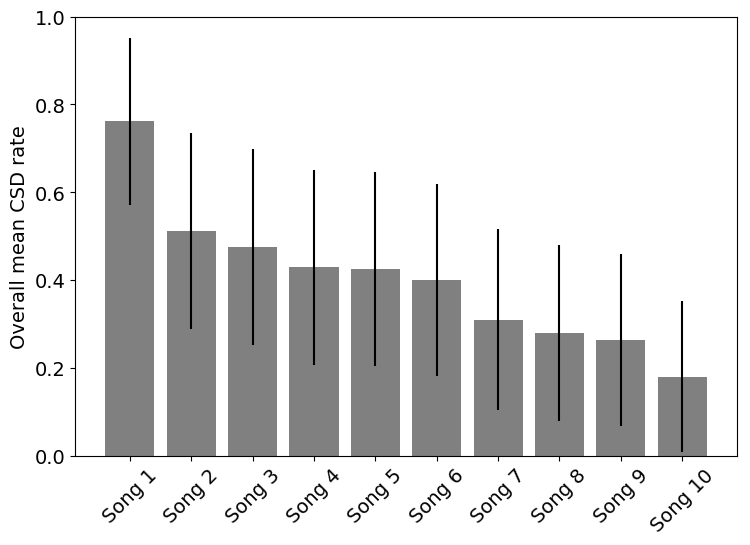

In [348]:
## Plot  Figure 1d, giving an overview of the playback rankings
from statsmodels.stats.anova import AnovaRM

a = 1 #aviary 2 is the birdracks 
daviary = all_aviaries[a]
meta = all_metas[a]


#daviary_binary = np.array(daviary[:,:,:,0])
#daviary_binary[daviary_binary != 1] = 0

daviary_binary = all_binary[a][:,:,:,0]

## Can't use ANOVA because the birds are the same-> repeated measures
#print(f_oneway(*np.nanmean(daviary_binary,1)))
print(meta.song_list)
#print(daviary_binary.shape)
fig,ax2 = plt.subplots()

## Plot individual mean responses
good_birds = np.nanmean(daviary_binary,axis=(1,2)) > .05

shuffled_s = np.random.permutation(np.arange(10))
sorted_s = np.argsort(np.nanmean(daviary_binary[good_birds],axis=(0,1)))[::-1]

#print(sorted_s,shuffled_s)
sorted_b = np.argsort(np.nanmean(daviary_binary,axis=(1,2)))[::-1]

for b in range(len(daviary_binary)):
    i = sorted_b[b]
    bar_means = np.nanmean(daviary_binary[i][:,shuffled_s],0)
    bar_std = np.nanstd(daviary_binary[i][:,shuffled_s],0)
    xs = np.arange(0,10) + .8*b/len(meta.bird_list)
    #ax1.bar(xs,bar_means,width=.8/len(meta.bird_list),color=cm.viridis(b/len(meta.bird_list)))

alphabet = 'ABCDEFGHIJ'
song_names = []
song_ranks = []
i_dict = {}
for i in range(10):
    song_names.append('Song ' + alphabet[i])
    i_dict[shuffled_s[i]]=alphabet[i]
for i in range(10):
    song_ranks.append('Song ' + str(i + 1))# + ' ('+i_dict[sorted_s[i]]+')')

#ax1.set_xticks(range(10))
#ax1.set_xticklabels(song_names,rotation=45)
#ax1.set_ylabel('Mean bird CSD rate')
#good_birds = np.nanmean(daviary_binary,axis=(1,2)) > .05

print('n_birds (excluding low responding birds):',np.sum(good_birds))
## Plot overall mean bird responses
bar_means = np.nanmean(daviary_binary[good_birds],axis=(0,1))
bar_sem = np.nanstd(daviary_binary[good_birds],axis=(0,1)) / np.sqrt(len(daviary_binary[good_birds]))



ax2.bar(np.arange(0,10),bar_means[sorted_s],yerr=bar_sem[sorted_s],color='gray')

#print(spearmanr(bar_means,np.arange(10)[::-1]))

ax2.set_xticks(range(10))
ax2.set_xticklabels(song_ranks,rotation=45)
ax2.set_ylabel('Overall mean CSD rate')

fig.tight_layout()

fig.set_size_inches([8,6])
#print([meta.song_list[i] for i in sorted_s])
#print(np.max(np.nanmean(daviary_binary[good_birds],axis=(0,1))))
#print(np.max(np.nanstd(daviary_binary[good_birds],axis=(0,1))))

In [559]:
## Stats on above Figure
from statsmodels.stats.anova import AnovaRM

bv2019_df = song_bird_df[song_bird_df['Aviary'] == 1]

#print(bv2019_df)
print(pd.unique(bv2019_df['Block']))
print(pd.unique(bv2019_df['Bird']))
print(AnovaRM(data=bv2019_df,depvar='Posture',
              subject='Bird',within=['Song'],aggregate_func='mean').fit())


[0 1 2 3 4 5 6 7 8 9 10 11 12 13]
['CB-White' 'CB-Orange' 'CB-Yellow' 'CB-Y2' 'CB-LB2']
              Anova
     Num DF  Den DF F Value Pr > F
----------------------------------
Song 9.0000 36.0000  4.0414 0.0012



In [560]:
## Run repeated measures ANOVA on all groups

#print(aviary_df[aviary_df['Bird'] == 'P1'])
for a in range(0,len(all_metas)):
    aviary_df = song_bird_df[song_bird_df['Aviary'] == a]

    for b in pd.unique(aviary_df['Bird']):
        #print(pd.unique(aviary_df[aviary_df['Bird']==b]['Song']))
        pass
    print('aviary:',str(a),'Birds:',pd.unique(aviary_df['Bird']))
    print('n_songs:',len(pd.unique(aviary_df['Song'])),pd.unique(aviary_df['Song']))
    print(AnovaRM(data=aviary_df,depvar='Posture',
                  subject='Bird',within=['Song'],aggregate_func='mean').fit())
    print('')


aviary: 0 Birds: ['P1' 'PINK2' 'Y1']
n_songs: 4 ['BDY' 'BOD' 'LB' 'DMG']
              Anova
     Num DF Den DF F Value Pr > F
---------------------------------
Song 3.0000 6.0000  1.5499 0.2960


aviary: 1 Birds: ['CB-White' 'CB-Orange' 'CB-Yellow' 'CB-Y2' 'CB-LB2']
n_songs: 10 ['BDY' 'BOD' 'ND' 'LB' '2M' 'DBR' 'GRG' 'WG' 'LNR' 'DMG']
              Anova
     Num DF  Den DF F Value Pr > F
----------------------------------
Song 9.0000 36.0000  4.0414 0.0012


aviary: 2 Birds: ['Wh14' 'GR11' 'WH19' 'WH24' 'LB20' 'GR13']
n_songs: 10 ['DY' 'OD' 'D' 'B' 'M' 'BR' 'RG' 'G' 'NR' 'MG']
              Anova
     Num DF  Den DF F Value Pr > F
----------------------------------
Song 9.0000 45.0000  8.2684 0.0000


aviary: 3 Birds: ['FGWL' 'FR2D' 'FNWD' 'FM2N']
n_songs: 12 ['B2M' 'MOL' 'BDY' 'LNR' 'W2R' 'BWD' 'YLO' 'NGO' 'YRM' '2YL' 'N2W' 'LYR']
               Anova
      Num DF  Den DF F Value Pr > F
-----------------------------------
Song 11.0000 33.0000  5.2255 0.0001


aviary: 4 Birds: ['FR2M

7
20 51
5
0.4539011118448627
0.32045912062618975


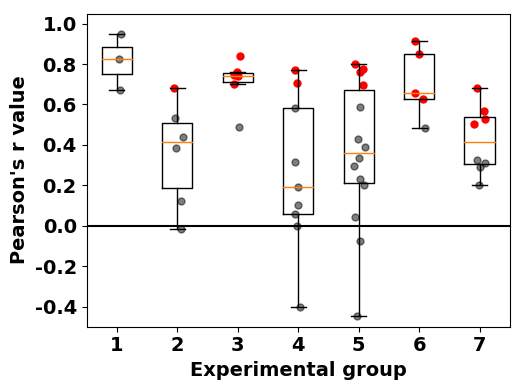

In [676]:
# Figure 1E - How much do birds agree? 

same_songs = [0,1,2,5,6]

fig,ax = plt.subplots()
count,p_count = 0,0
all_std,random_stds = [],[]
iterations = 1000
boxes_concs = []
sig_count = 0
all_ps = []
print(len(all_aviaries))
skip = 0
for a in range(len(all_aviaries)):

    #responsive_birds = []
    bird_concs = []
    bird_ps = []
    daviary = all_aviaries[a][:,:,:,0]
    n_birds = daviary.shape[0]
    n_blocks = daviary.shape[1]
    responsive_birds = np.nanmean(daviary,axis=(1,2)) > .05
    for f in range(n_birds):
        this_bird = daviary[f,:,:]
        if np.nanmean(this_bird) <= .05:
            if verbose:
                print('non_responsive!',a+1,f+1)
            continue
        not_f = np.arange(n_birds) != f
        good_songs = ~np.isnan(np.nanmean(daviary[f,:,:],axis=0))
        good_songs_all = ~np.isnan(np.nanmean(daviary[not_f,:,:],axis=(0,1)))
        gsi = good_songs & good_songs_all
        #bird_conc,p_value = pearsonr(np.nanmean(daviary[f,:,gsi],axis=0),np.nanmean(daviary[not_f,:,gsi],axis=(0,1)))
        bird_conc,p_value = pearsonr(np.nanmean(daviary[f,:][:,gsi],axis=0),
                             np.nanmean(daviary[not_f,:][:,:,gsi],axis=(0,1)))
        #random_birds = np.shuffle(np.nanmean(daviary[f,:,:],axis=0))
        #random_conc,_ = pearsonr(random_birds,np.nanmean(daviary[not_f,:,:],axis=(0,1)))
        #bird_concs.append(1 - p_value)
        if ~np.isnan(bird_conc):
            bird_concs.append(bird_conc)
            bird_ps.append(p_value)
        else:    
            #print('no correlation',a,f,bird_conc,np.nanmean(daviary[f,:,:,],0),np.nanmean(daviary[not_f,:,:],axis=(0,1)))
            continue
            
        #rand_concs.append(random_conc)
        if verbose:
            print('Aviary/bird:',a+1,f+1,bird_conc,p_value)
        if p_value <= .05:
            p_count += 1
        count += 1
    xs = np.ones(len(bird_concs)) * a + np.random.uniform(low=-.1,high=.1,size=len(bird_concs))
    #print(bird_concs)
    bird_concs = np.array(bird_concs)
    bird_ps = np.array(bird_ps)
    all_ps.append(bird_ps)
    bird_concs_sig = bird_concs[bird_ps < .05]
    bird_concs_non = bird_concs[bird_ps >= .05]
    #print('sig,non',bird_concs_sig,bird_concs_non)
    boxes_concs.append(bird_concs)
    sig_count += len(bird_concs_sig)
    
    if a not in same_songs:
        skip += 1
    else:
        xs_sig = np.ones(len(bird_concs_sig)) * (a-skip) + np.random.uniform(low=-.1,high=.1,size=len(bird_concs_sig))
        xs_non = np.ones(len(bird_concs_non)) * (a-skip) + np.random.uniform(low=-.1,high=.1,size=len(bird_concs_non))

        ax.scatter(xs_sig,bird_concs_sig,color='red',marker='.',s=100)
        ax.scatter(xs_non,bird_concs_non,color='black',marker='.',alpha=.5,s=100)
    if a in [3,4]:

        xs_sig = np.ones(len(bird_concs_sig)) * (a+2) + np.random.uniform(low=-.1,high=.1,size=len(bird_concs_sig))
        xs_non = np.ones(len(bird_concs_non)) * (a+2) + np.random.uniform(low=-.1,high=.1,size=len(bird_concs_non))

        ax.scatter(xs_sig,bird_concs_sig,color='red',marker='.',s=100)
        ax.scatter(xs_non,bird_concs_non,color='black',marker='.',alpha=.5,s=100)
    
    #ax.scatter(xs,bird_concs)

ax.boxplot([boxes_concs[s] for s in [0,1,2,5,6,3,4]],positions=range(7),showfliers=False)
#ax.boxplot([boxes_concs[s] for s in [3,4]],positions=[5,6],showfliers=False)

#ax.set_xlim([-1,8])
f_dict = {
    'fontsize':14,
    'fontweight':'bold',
    'fontname':'arial'
}
f_size = 14
f_weight = 'heavy'
f_name = 'arial'
#ax.axhline(.95,color='red',linestyle=':')
#ax.set_title('Most birds correlate strongly with group')
ax.set_xlabel('Experimental group',fontdict=f_dict)
ax.set_ylabel("Pearson's r value",fontdict=f_dict)
ax.axhline(0,color='black')
ax.set_xticklabels(range(1,8),fontsize=f_size,fontdict=f_dict)
ax.set_yticks(np.arange(-0.4,1.01,.2))
ax.set_yticklabels(np.round(np.arange(-0.4,1.01,.2),2),fontdict=f_dict)
ax.set_ylim(-.50,1.05)
fig.set_size_inches(8/1.5,6/1.5)

fig.tight_layout()
fig.show()
fig.savefig('./figures/Fig1E.svg')

if True:
    print(p_count,count)
    #print(np.nanmean(all_std))
    
    neg_corr = 0
    for c in boxes_concs:
        neg_corr += np.sum(np.array(c) <= 0)
    print(neg_corr)

    flat_cs = []
    for cs in boxes_concs:
        #print(ps)
        flat_cs.extend(cs)
    print(np.nanmean(flat_cs))
    print(np.nanstd(flat_cs))

## Figure 2:
Showing the shift in responsiveness over the course of the experiment

Bird array shape: (8, 11, 10)
N active birds: [False  True  True False  True  True  True  True]


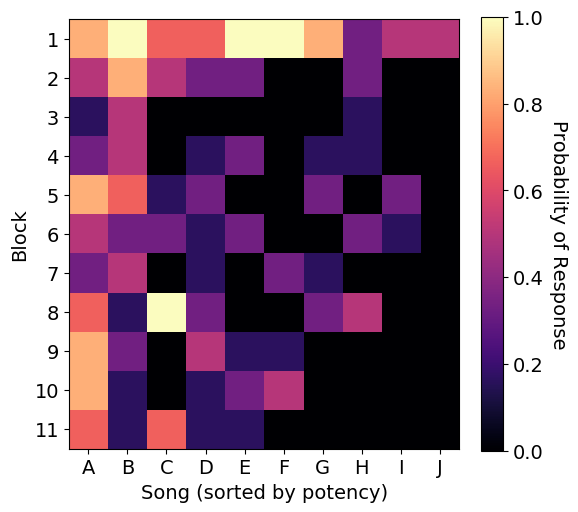

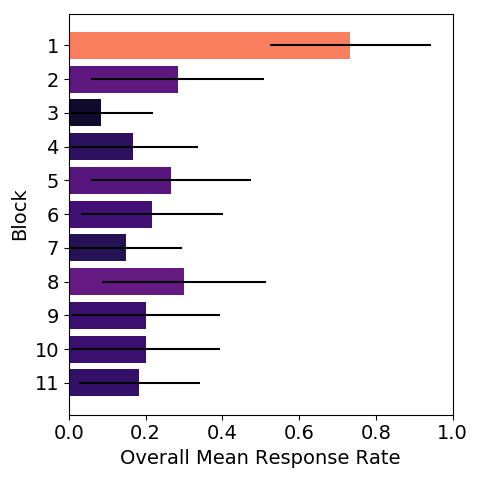

In [356]:
## Plot example results for Fig 2A-B: 

#plt.style.use('dark_background')

daviary = all_aviaries[2][:,:,:,0]
n_blocks = daviary.shape[1]
song_order = np.argsort(np.nanmean(daviary,axis=(0,1)))[::-1]
n_birds = daviary.shape[0]
print('Bird array shape:',daviary.shape)
active_birds = np.nanmean(daviary,axis=(1,2)) > .05
print('N active birds:',active_birds)
heat_map = np.nanmean(daviary[active_birds,:][:,:,song_order],axis=(0))
#print(heat_map.shape)
fig,ax= plt.subplots()
block_map = ax.imshow(heat_map,vmax=1.0,vmin=0,cmap='magma')
ax.set_xlabel('Song (sorted by potency)')
ax.set_ylabel('Block')
#ax.set_title('Response rate (averaged across birds)\n')

#print(heat_map)
ax.set_xticks(np.arange(heat_map.shape[1]))
ax.set_xticklabels(['A','B','C','D','E','F','G','H','I','J'])

ax.set_yticks(np.arange(heat_map.shape[0]))
ax.set_yticklabels(np.arange(1,heat_map.shape[0] + 1))
cbar = fig.colorbar(block_map,ax=ax,fraction=0.05)
cbar.ax.set_ylabel('Probability of Response', rotation=-90, va="bottom")
fig.set_size_inches([6,6])
fig.tight_layout()
fig.savefig('./figures/resp_rate_heatmap_dark.png',dpi=300)
fig.show()

fig1,ax1 = plt.subplots()
bar_std = np.nanstd(daviary[active_birds],axis=(0,2)) / np.sqrt(active_birds.sum())
bar_mean = np.nanmean(daviary[active_birds],axis=(0,2))
#print(bar_mean,bar_std)
song_std = np.nanstd(daviary[active_birds],axis=(0,1)) / np.sqrt(active_birds.sum())
song_mean = np.nanmean(daviary[active_birds],axis=(0,1))

ax1.barh(np.arange(1,1+n_blocks)[::-1],bar_mean,xerr=bar_std,color=cm.magma(bar_mean),ecolor='black')
ax1.set_yticks(range(1,1+n_blocks))
ax1.set_yticklabels(np.arange(1,1+n_blocks)[::-1])
ax1.set_ylabel('Block')
ax1.set_xlabel('Overall Mean Response Rate')
#ax1.set_title('General response rate changes over playbacks')
ax1.set_xlim([0,1])
fig1.set_size_inches(5,5)
fig1.tight_layout()
fig1.savefig('./figures/resp_rate_bars_dark.png',dpi=300)
fig1.show()

#fig2,ax2 = plt.subplots()

#song_order = np.argsort(song_mean)[::-1]
"""
ax2.bar(['A','B','C','D','E','F','G','H','I','J'],song_mean[song_order],yerr=song_std[song_order],color=cm.magma(song_mean[song_order] + .2),ecolor='white')
ax2.set_ylim([0,1])
ax2.set_ylabel('Response Rate')
ax2.set_xlabel('Song')
fig2.set_size_inches(6,4)
fig2.tight_layout()
fig2.show()
fig2.savefig('./figures/Song_response_rate_dark.png',dip=300)"""
pass

In [550]:
## Quick ANOVA on above info
print(AnovaRM(data=bv2019_df[bv2019_df['Block']<=11],depvar='Posture',subject='Block',within=['Song'],aggregate_func='mean').fit())

              Anova
     Num DF  Den DF F Value Pr > F
----------------------------------
Song 9.0000 99.0000  4.8937 0.0000



## Figure 3: 
Testing the predictions of the CSD Model

In [640]:
# Calculate data points for Fig 5a: Does top song response rate correlate with everything else? 
#plt.style.use('default')
#plt.style.use('dark_background')

## Need to save these into a database, so that I can keep them and feed them into a mixed model. 

#levene([1,0,1,0,1,0,1,0,1],[1,1,1,1,1,1,1,1,1])
#print(binary_array3.shape)
#print(daviary.shape)

all_song_rates,top_song_rates = [],[]
columns_s = ['All_ResponseRate','S1_ResponseRate','Aviary','Block','SongSet']
columns_sb = ['ResponseRate','Posture','AvgPotency','Bird','Block','Song','Aviary','SongSet']
song_sets = [0,0,0,1,2,0,0]

song_df = pd.DataFrame(columns=columns_s)
song_bird_df = pd.DataFrame(columns=columns_sb)
max_song_df = pd.DataFrame(columns=columns_sb)
for a in range(len(all_aviaries)):
    #print(all_metas[a].n_birds)
    
    daviary = np.array(all_aviaries[a][:,:,:,0])
    daviary[daviary == 2] = 0 
    
    responsive_birds = np.nanmean(daviary[:,:,:],axis=(1,2)) > .05
    
    print(responsive_birds)
    d_potency = np.nanmean(daviary[responsive_birds],axis=(0,1))
    top_song_index = np.argmax(np.nanmean(daviary,axis=(0,1)))

    top_song_index = np.argmax(np.nanmean(daviary,axis=(0,1)))
    not_top_indices = np.arange(daviary.shape[2]) != top_song_index
    
    ys = np.nanmean(daviary[:,:,not_top_indices],axis=(0,2))
    top_ys = np.nanmean(daviary[:,:,top_song_index],axis=0)

    ## Plot the weights (first non-controlled)
    ## Normalize by top song
    weights = np.nanmean(daviary,axis=0)
    top_song_weights = weights[:,top_song_index]

    all_song_rates.extend(ys)
    top_song_rates.extend(top_ys)
    n_birds = all_metas[a].n_birds
    n_songs = all_metas[a].n_songs
    for b in range(len(ys)):
        #print(a,b)
        song_df = song_df.append(dict(zip(columns_s,[ys[b],top_ys[b],a,b,song_sets[a]])),ignore_index=True)
        for f in range(n_birds):
            if not responsive_birds[f]:
                continue
            bird = all_metas[a].bird_list[f]
            for s in range(n_songs):
                fs_response = np.nanmean(daviary[f,b,:][np.arange(n_songs) != s])
                if np.isnan(daviary[f,b,s]):
                    continue
                f_posture = daviary[f,b,s]
                song = all_metas[a].song_list[s]
                if a>=2:
                    song = song[1:]
                song_bird_df = song_bird_df.append(dict(zip(columns_sb,
                                            [fs_response,f_posture,d_potency[s],bird,b,song,a,song_sets[a]])),ignore_index=True)
                if s == top_song_index:
                    max_song_df = max_song_df.append(dict(zip(columns_sb,
                                            [fs_response,f_posture,d_potency[s],bird,b,song,a,song_sets[a]])),ignore_index=True)
    if False:
        fig,(ax1,ax2) = plt.subplots(2,sharex=True)
        ax1.bar(range(len(ys)),top_ys,alpha = .5,label='Top Song')
        ax1.bar(range(len(ys)),ys,label='All other songs')
        ax1.legend()
        for s in range(daviary.shape[2]):
            ax2.plot(range(len(weights[:,s])),weights[:,s])
        ax2.set_xlabel('Block')
        ax1.set_ylabel('Mean Response Rate')
        ax2.set_ylabel('Mean Response Rate \n(by song)')
        fig.set_size_inches(6,4)
        fig.show()


#print(np.unique(top_song_rates),np.unique(all_song_rates))

song_bird_df = song_bird_df.dropna()
max_song_df = max_song_df.dropna()
if True:
    song_df.to_csv('./song_df2.csv',index=False)

    song_bird_df.to_csv('./song_bird_df2.csv',index=False)


    max_song_df.to_csv('./max_song_df2.csv',index=False)

[ True  True  True]
[ True  True  True False  True  True False]
[False  True  True False  True  True  True  True]
[ True  True False False False False False  True  True False False]
[False  True  True False  True  True False False False False False  True
 False False]
[ True  True  True  True  True  True False False  True False]
[ True  True  True  True False  True  True  True False  True False  True
 False False False]


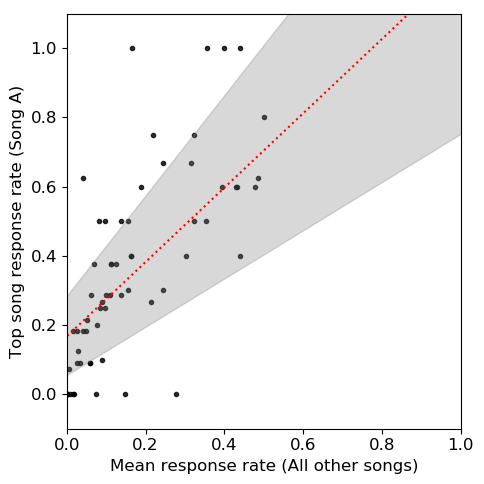

In [644]:
# Plot Fig 5a
plt.rcParams.update({'font.size': 12})
#plt.rcParams.update({'axes.labelweight':'bold'})

## These values are calculated from stats_script.py
rate_effect,rate_intercept = 1.074,0.167
intercept_range = [0.053,0.281]
effect_range = [0.697,1.450]


fig,ax = plt.subplots()
#fit_line = np.poly1d(np.polyfit(top_song_rates,all_song_rates,1))
effect_line = np.poly1d([rate_effect,rate_intercept])
effect_low = np.poly1d([effect_range[0],intercept_range[0]])
effect_high = np.poly1d([effect_range[1],intercept_range[1]])

ax.scatter(all_song_rates,top_song_rates,color='black',alpha=.8,marker='.')

x_range = np.linspace(-0.2,1.2,10)
ax.plot(x_range,effect_line(x_range),color='red',linestyle=':')


ax.fill_between(x_range,effect_low(x_range),effect_high(x_range),color='gray',alpha=.3)
ax.set_ylabel('Top song response rate (Song A)')
ax.set_xlabel('Mean response rate (All other songs)')
#ax.set_title('Top song response rate correlates with overall response rate\n')
#print(pearsonr(all_song_rates,top_song_rates))
ax.set_xlim([0,1.0])
ax.set_ylim([-0.1,1.1])
fig.set_size_inches(5,5)
fig.tight_layout()

fig.savefig('./figures/Fig3a.png',dpi=300)
fig.show()

In [645]:
## Get Points for Fig 3b: Does early selectivity correlate with late selectivity? 
## Block1 vs Rest: 1 significant, 2 nearly significant, but not quite. Pearson is better
## Block1-3 vs Rest: 3/5 significant
## Block1-2 vs Rest: 3/5 Significant, nicer numbers

#plt.style.use('default')
plt.rcParams.update({'font.size': 12})

columns_b = ['B1_Rate','Later_Rate','AvgPotency','Song','Aviary','SongSet']
columns_bf = ['B1_Posture','Later_Rate','AvgPotency','Bird','Song','Aviary','SongSet']
block_df = pd.DataFrame(columns=columns_b)
f_block_df = pd.DataFrame(columns=columns_bf)
## Rank or straight correlation:
xs,ys = [],[]
song_sets = [0,0,0,1,2,0,0]
for d in range(len(all_aviaries)):
    daviary = np.array(all_aviaries[d][:,:,:,0])
    

    daviary[daviary == 2] = 0
    responsive_birds = np.nanmean(daviary,axis=(1,2)) > .05
    
    d_potency = np.nanmean(daviary[responsive_birds],axis=(0,1))
    s_set = song_sets[d]
    i = 1 ## Starting index (could be 2, could be 4, etc)
    block1_rank = np.nanmean(daviary[responsive_birds,0,:],axis=(0))
    overall_rank = np.nanmean(daviary[responsive_birds,i:,:],axis=(0,1))
    overall_bird_rank = np.nanmean(daviary[responsive_birds,i:,:],axis=1)
    xs.extend(block1_rank)
    ys.extend(overall_rank)
    #print(overall_rank)                       
    #print(block1_rank)
    n_females = all_metas[d].n_birds
    #print(spearmanr(overall_rank,block1_rank))
    if verbose:
        print(pearsonr(block1_rank,overall_rank))
    for s in range(len(block1_rank)):
        song=all_metas[d].song_list[s]
        if d>=2:
            song = song[1:]
        block_df = block_df.append(dict(zip(columns_b,
                                [block1_rank[s],overall_rank[s],d_potency[s],song,d,s_set])),ignore_index=True)
        shift = 0
        for f in range(n_females):
            if not responsive_birds[f]:
                shift -= 1
                #print('skipping',f)
                continue
            #print(f,overall_bird_rank.shape)
            bird = all_metas[d].bird_list[f]
            posture_zero = daviary[f,0,s]
            bs_rate = overall_bird_rank[f+shift,s]
            f_block_df = f_block_df.append(dict(zip(columns_bf,
                                    [posture_zero,bs_rate,d_potency[s],bird,song,d,s_set])),ignore_index=True)
        
#fit_line = np.poly1d(np.polyfit(xs,ys,1))

#print('overall:',pearsonr(xs,ys))


## Build dataframes
block_df = block_df.dropna()

f_block_df = f_block_df.dropna()

## Save them (you already have these, change them at your own risk)
if True:
    f_block_df.to_csv('./f_block_df2.csv',index=False)
    block_df.to_csv('./block_df2.csv',index=False)
print('Done!')

Done!


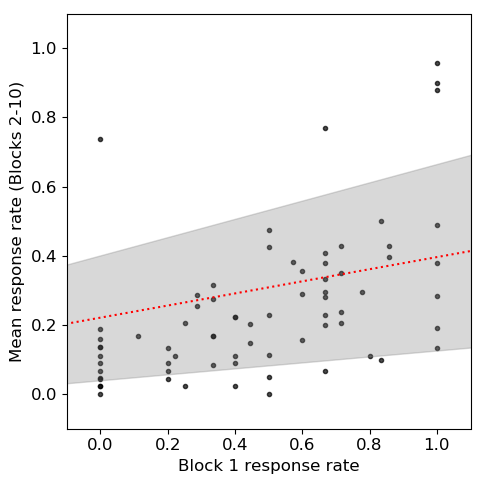

In [646]:
## Plot Fig 3b
#plt.rcParams.update({'font.size': 12})
#plt.rcParams.update({'axes.labelweight':'normal'})

fig,ax = plt.subplots()

ax.scatter(xs,ys,color='black',alpha=.7,marker='.')

effect,intercept = [0.175,0.221]
effect_low,effect_high = [0.086,0.264]
intercept_low,intercept_high = [0.040,0.401]
fit_line = np.poly1d([effect,intercept])
low_line = np.poly1d([effect_low,intercept_low])
high_line = np.poly1d([effect_high,intercept_high])

x_range = [-0.2,1.2]
ax.plot(x_range,fit_line(x_range),color='red',linestyle=':')
ax.fill_between(x_range,low_line(x_range),high_line(x_range),color='gray',alpha=.3)
ax.set_xlabel('Block 1 response rate')
ax.set_ylabel('Mean response rate (Blocks 2-10)')
ax.set_xlim([-.1,1.1])
ax.set_ylim([-.1,1.1])
#ax.set_title('Song CSD-rate stay largely consistent following first block\n')
fig.set_size_inches(5,5)

fig.tight_layout()
fig.savefig('./figures/Fig3b.png',dpi=300)
fig.show()

## Figure 5
Understanding Partial Postures. 5F is one of my favorite tests I've ever done, even though it's a bit obtuse

working...
Done
intercept,effect: 0.241 0.091
Full CSD: 0.3260130513107387 0.16256249667352304 482
Partial CSD: 0.26582109300703877 0.1602955730956318 237
Non CSD: 0.21372973919618682 0.1425534789272305 855
Ttest_indResult(statistic=-4.6820705305332435, pvalue=3.396687921594404e-06)
Ttest_indResult(statistic=4.836364414468089, pvalue=1.5122172145917456e-06)


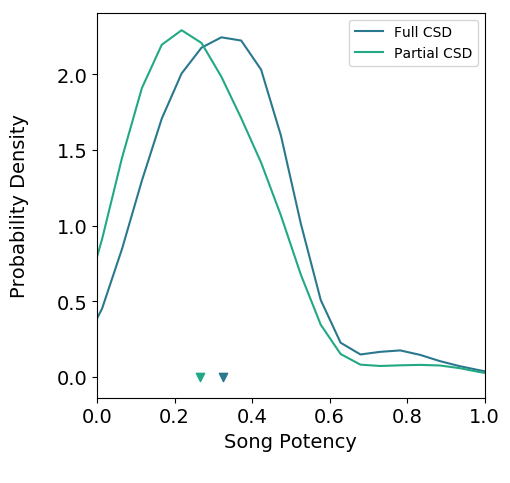

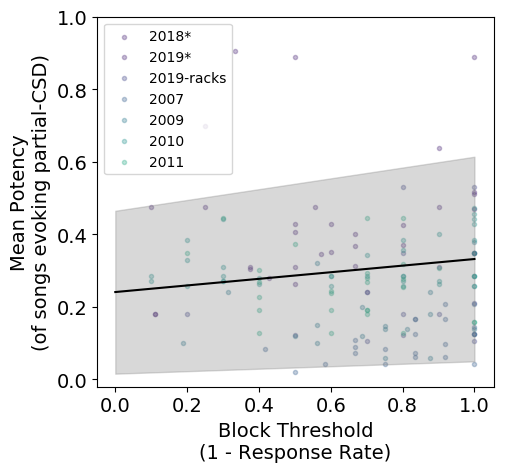

In [583]:
## Check whether partials correlate with reponse rate for Fig 5E-F This takes some time
paper_cmap = cm.get_cmap('viridis')
#all_aviaries = daviaries.extend([birdview_array,bv3_array])
#all_metas = dmetas.extend([birdview_meta,bv3_meta])

aviary_color_values = [.1,.1,.2,.3,.4,.5,.6,.7,.8]
aviary_colors = [paper_cmap(v) for v in aviary_color_values]

"""
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
"""

plt.rcParams.update({
    'font.size':14,
    'font.family':'Arial',
    'figure.facecolor':'white'})

plot_aviary_names = [
    '2018*',
    '2019*',
    '2019-racks',
    '2007',
    '2009',
    '2010',
    '2011'
]
xs_all,ys_all = [],[]
all_partials,all_postures = [],[]
all_nons = []
#all_durations = []
ys_rel = []

fig,ax1 = plt.subplots()
fig1,ax = plt.subplots()

columns = ["ResponseRate","N_Partials","RelPotency","AvgPotency","Bird","Block","Aviary","SongSet","Threshold"]
columns2 = ["ResponseRate","Duration","LogDuration","RelPotency","AvgPotency","Bird","Block","Song","Aviary","SongSet"]
columns_csd = ["Partial_CSD","AvgPotency","Bird","Block","ResponseRate","Song","Aviary","SongSet"]

partials_df = pd.DataFrame(columns=columns)
durations_df = pd.DataFrame(columns=columns2)
csd_df = pd.DataFrame(columns=columns_csd)
"""
partials_df = pd.DataFrame({
    "ResponseRate":[],
    "RelPotency":[],
    "AvgPotency":[],
    "Bird":[],
    "Block":[],
    "Aviary":[]
    })
"""
song_sets = [0,0,0,1,2,0,0]
print('working...')
for d in range(len(all_aviaries)):

    xs,ys,no_partials = [],[],[]
    ys_rel = []
## pull out block response rate and mean potency of partial songs:
    daviary = np.array(all_aviaries[d])
    #print(daviary[:,:,:,0] == 2)
    #print(daviary.shape)
    #print(np.unique(daviary[:,:,:,0]))
    meta = all_metas[d]
    binary_dave = all_binary[d]
    
    responsive_birds = np.nanmean(binary_dave[:,:,:,0],axis=(1,2)) > .05
    #print(responsive_birds)
    dave_potency = np.nanmean(binary_dave[responsive_birds,:,:,0],axis=(0,1))
    #print(dave_potency)
    dave_potency = dave_potency # / np.max(dave_potency)
    aviary_name = plot_aviary_names[d] #meta.name
    #xs,ys,no_partials = [],[],[]
    for f in range(meta.n_birds):
        female = meta.bird_list[f]
        rel_potency = np.nanmean(binary_dave[f,:,:,0],0)
        f_response,f_sum = np.nanmean(binary_dave[f,:,:,0]),np.nansum(binary_dave[f,:,:,0])
        #print(f_response,f_sum)
        if f_sum < 5 or f_response < .05:
            if verbose:
                print('dropping',a,f,f_response,f_sum)
            continue
        #print(max(rel_potency))
        for b in range(meta.n_blocks):
            #print(f,b)
            block_r = np.nanmean(binary_dave[f,b,:,0])# / np.max(dave_potency)
            block_partials = [daviary[f,b,:,0] == 2]
            n_block_partials = np.sum(block_partials)
            block_non = [daviary[f,b,:,0] == 0]
            mean_duration = np.mean(daviary[f,b,:,2][daviary[f,b,:,0] == 1])
            #print(block_partials,dave_potency)
            partial_potency = dave_potency[block_partials] #/ np.max(dave_potency)
            non_potency = dave_potency[block_non]
            for s in range(meta.n_songs):
                partial_csd = daviary[f,b,s,0] - 1
                song = meta.song_list[s]
                song_potency = dave_potency[s]
                if partial_csd == -1:
                    continue
                else:
                    csd_df = csd_df.append(dict(zip(columns_csd,
                                                [partial_csd,song_potency,female,b,block_r,song,d,song_sets[d]])),ignore_index=True)
                duration = daviary[f,b,s,2]
                
                if duration==0:
                    continue
                log_duration = np.log(duration)
                if np.isnan(duration):
                    continue
                if duration == 'R':
                    continue
                rel_song_potency = rel_potency[s]

                durations_df = durations_df.append(dict(zip(columns2,
                            [block_r,duration,log_duration,rel_song_potency,song_potency,
                             female,b,song,aviary_name,song_sets[d]])),ignore_index=True)
            if len(partial_potency) >= 1:
                mean_potency = np.mean(partial_potency)
                mean_rel = np.mean(rel_potency[block_partials])
            ## If no partials,  no data...right? 
            else:
                #print('no partials')
                no_partials.append(block_r)
                continue
            #print(block_r,dave_potency[block_partials])
            #print(block_r,mean_potency)
            xs.append(block_r)
            ys.append(mean_potency)
            ys_rel.append(mean_rel)
            xs_all.append(block_r)
            ys_all.append(mean_potency)
            #all_durations.append(mean_duration)
            all_partials.extend(partial_potency)# / np.max(dave_potency))
            all_postures.extend(dave_potency[binary_dave[f,b,:,0] == 1]) ## Also add song distribution
            all_nons.extend(non_potency) ## Also get 'non' distribution
            partials_df = partials_df.append(dict(zip(columns,
                                        [block_r,n_block_partials,mean_rel,mean_potency,female,b,aviary_name,song_sets[d],1-block_r])),ignore_index=True)
    ax.scatter(1-np.array(xs),ys,color=aviary_colors[d],marker='.',alpha=.3,label=aviary_name)
    #print(xs,ys)
    #fit_line = np.poly1d(np.polyfit(xs,ys,1))
    #ax.plot([0,1],fit_line([0,1]),linestyle=':',color=aviary_colors[d],alpha=.5)
    if verbose:
        print(pearsonr(xs,ys))
        print(xs,ys)


#print(pd.unique(durations_df['AvgPotency']))
durations_df.to_csv('./durations_df4.csv',index=False)
partials_df.to_csv('./partials_df3.csv',index=False)
#csd_df.to_csv('./csd_df3.csv',index=False)    
#print(partials_df)
    
"""
## run the mixed linear model so I can plot the curve
partials_df = partials_df.dropna()
md = smf.mixedlm("AvgPotency ~ ResponseRate",data=partials_df,groups=partials_df["Aviary"])
mdf_partial = md.fit()    
intercept,effect,_ = mdf_partial.params
"""
print('Done')

intercept,effect = [0.241,0.091]
int_low,int_high = [0.016,0.465]
eff_low,eff_high = [0.034,0.149]

print('intercept,effect:',intercept,effect)

fit_line = np.poly1d([effect,intercept])
low_line = np.poly1d([eff_low,int_low])
high_line = np.poly1d([eff_high,int_high])


#ax.scatter(partials_df['ResponseRate'],partials_df['AvgPotency'],alpha=.4,marker='.')
ax.plot([0,1],fit_line([0,1]),color='black')
ax.fill_between([0,1],high_line([0,1]),low_line([0,1]),color='gray',alpha=.3)

ax.legend(fontsize=10)
ax.set_ylim([-0.02,1])

ax.set_xlabel('Block Threshold\n(1 - Response Rate)')
ax.set_ylabel('Mean Potency\n(of songs evoking partial-CSD)')
#ax.scatter(xs,ys)
fit_line = np.poly1d(np.polyfit(xs_all,ys_all,1))
#ax.plot([0,1],fit_line([0,1]),color='red')
#par_xs,par_ys,_ = ax1.hist(all_partials,normed=True,alpha=.6,label='partials')
#csd_xs,csd_ys,_ = ax1.hist(all_postures,normed=True,alpha=.6,label='postures')
BW = .5
csd_curve = gaussian_kde(all_postures,bw_method=BW)
csd_xs = np.linspace(-0.5,1.5,40)
ax1.plot(csd_xs,csd_curve(csd_xs),color=paper_cmap(.4),label='Full CSD')

par_curve = gaussian_kde(all_partials,bw_method=BW)
ax1.plot(csd_xs,par_curve(csd_xs),color=paper_cmap(.6),label='Partial CSD')
ax1.scatter(np.nanmean(all_postures),0.0,marker='v',color=paper_cmap(.4))
ax1.scatter(np.nanmean(all_partials),0.0,marker='v',color=paper_cmap(.6))
print('Full CSD:',np.nanmean(all_postures),np.nanstd(all_postures),np.sum(~np.isnan(all_postures)))
print('Partial CSD:',np.nanmean(all_partials),np.nanstd(all_partials),np.sum(~np.isnan(all_partials)))
print('Non CSD:',np.nanmean(all_nons),np.nanstd(all_nons),np.sum(~np.isnan(all_nons)))
ax1.set_xlim([0,1])
ax1.set_xlabel('Song Potency\n')
ax1.set_ylabel('Probability Density\n')
ax1.legend(fontsize=10)
print(ttest_ind(all_partials,all_postures))
print(ttest_ind(all_partials,all_nons))

plt.tight_layout()
fig.set_size_inches(5,5)
fig.show()
fig.savefig('./figures/Fig5e.png',dpi=300,bbox_inches='tight')

plt.tight_layout()
fig1.set_size_inches(5,5)
fig1.show()
fig1.savefig('./figures/Fig5f.png',dpi=300,bbox_inches='tight')

In [437]:
print(len(durations_df))

832


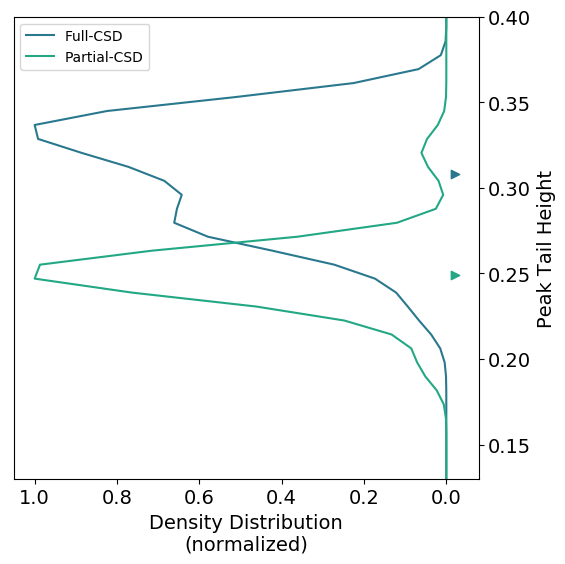

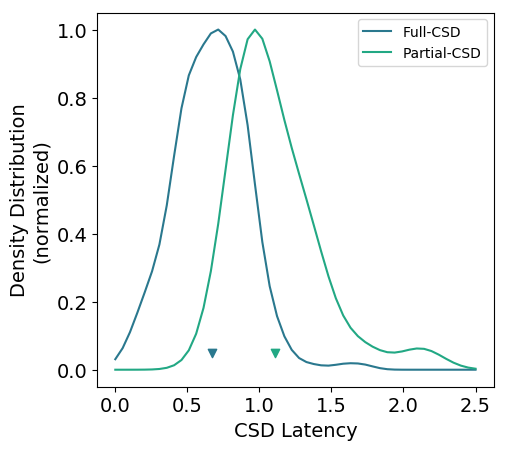

In [439]:
### Comparing partial to full for Fig5 C,D


partial_peaks = []
full_peaks = []
for s in os.listdir('./SeqClasses/'):
    if '2019' not in s:
        continue
    try: 
        seq = pickle.load(open('./SeqClasses/' + s,'rb'))
    except:
        print(s,'failed')
        continue
    if seq.posture == 1:
        try:
            t3_index = np.argmax(seq.ts > 3)
            t1_index = np.argmax(seq.ts >= 1)
            t0_index = np.argmax(seq.ts >= 0)
            tb_index = np.argmax(seq.ts > -1)

            foot_norm = np.nanmedian(np.vstack([seq.smooth_data[tb_index:t0_index,11,2],seq.smooth_data[tb_index:t0_index,11,2]]))
            back_norm = np.nanmedian(np.vstack([seq.smooth_data[t1_index:t3_index,3,2],seq.smooth_data[t1_index:t3_index,9,2]]))
            #foot_norm = back_norm
            foot_norm = 0.0
            if ~np.isnan(foot_norm) and ~np.isnan(seq.peak_height):
                full_peaks.append(seq.peak_height - foot_norm)

        except:
            pass
        continue
    elif seq.posture != 2:
        continue
    
    t3_index = np.argmax(seq.ts > 3)
    t1_index = np.argmax(seq.ts >= 1)
    t0_index = np.argmax(seq.ts >= 0)
    tb_index = np.argmax(seq.ts > -1)
    foot_norm = np.nanmedian(np.vstack([seq.smooth_data[tb_index:t0_index,11,2],seq.smooth_data[tb_index:t0_index,12,2]]))
    back_norm = np.nanmedian(np.vstack([seq.smooth_data[t1_index:t3_index,3,2],seq.smooth_data[t1_index:t3_index,9,2]]))
    #foot_norm = back_norm
    foot_norm = 0.0
    partial_peak = np.nanmax(seq.smooth_data[t1_index:t3_index,10,2])

    if ~np.isnan(foot_norm) and ~np.isnan(partial_peak):
        partial_peaks.append(partial_peak - foot_norm)
    #print(partial_peaks)
    if False:
        plt.cla()
        plt.plot(seq.ts,seq.data[:,10,2])
        plt.axvline(3,linestyle=':')

        plt.axhline(partial_peak,color='red')

        #print(np.unique(seq.data[:,10,2]))
        try:
            plt.axvline(seq.tzero)
        except:
            plt.axvline(seq.offset)
        plt.title(seq.seq_name)
        plt.show()

partial_array = np.array(partial_peaks) #[~np.isnan(np.array(partial_peaks))]
#print(partial_array)
full_array = np.array(full_peaks)

partial_array = partial_array[partial_array > 0.15]
full_array = full_array[full_array > .15]


a = .5
partial_peak_pdf =  gaussian_kde(partial_array)
full_peak_pdf = gaussian_kde(full_array)
clumped_peak_pdf = gaussian_kde(np.hstack([partial_array,full_array]))


fig1,ax1 = plt.subplots()
fig2,ax2 = plt.subplots()

#ax.scatter(np.zeros(len(partial_array)),partial_array)
#ax.scatter(np.ones(len(full_array)),full_array)
xs = np.linspace(0.10,.50,50)
#xs = np.linspace(np.min(partial_array),np.max(full_array),50)

#ax1.plot(xs,full_peak_pdf(xs)/max(full_peak_pdf(xs)),label='Full-CSD',color=paper_cmap(.4))
#ax1.plot(xs,partial_peak_pdf(xs)/max(partial_peak_pdf(xs)),label='Partial-CSD',color=paper_cmap(.6))
ax1.plot(full_peak_pdf(xs)/max(full_peak_pdf(xs)),xs,label='Full-CSD',color=paper_cmap(.4))
ax1.plot(partial_peak_pdf(xs)/max(partial_peak_pdf(xs)),xs,label='Partial-CSD',color=paper_cmap(.6))

#ax1.plot(xs,clumped_peak_pdf(xs)/max(clumped_peak_pdf(xs)),label='Partial- & Full-CSD',color='gray')

#ax1.scatter(np.mean(full_array),0.05,color=paper_cmap(.4),marker='v')
#ax1.scatter(np.mean(partial_array),0.05,color=paper_cmap(.6),marker='v')
ax1.scatter(-0.02,np.mean(full_array),color=paper_cmap(.4),marker='>')
ax1.scatter(-0.02,np.mean(partial_array),color=paper_cmap(.6),marker='>')
ax1.set_ylim([0.13,0.40])

#fig.show()

#fig,ax = plt.subplots()
if verbose:
    print(partial_latencies)
partial_lat_array = np.array(partial_latencies)
full_lat_array = np.array(csd_latencies)

partial_lat_array = partial_lat_array[~np.isnan(partial_lat_array)]
full_lat_array = full_lat_array[~np.isnan(full_lat_array)]

full_latency_pdf = gaussian_kde(full_lat_array)
partial_latency_pdf = gaussian_kde(partial_lat_array)

clumped_latency_pdf = gaussian_kde(np.hstack([partial_lat_array,full_lat_array]))

#ax.scatter(np.zeros(len(partial_lat_array) + len(full_lat_array)),np.hstack([partial_lat_array,full_lat_array]))

xs = np.linspace(0,2.5,50)
ax2.plot(xs,full_latency_pdf(xs)/max(full_latency_pdf(xs)),label='Full-CSD',color=paper_cmap(.4))
ax2.plot(xs,partial_latency_pdf(xs)/max(partial_latency_pdf(xs)),label='Partial-CSD',color=paper_cmap(.6))
#ax2.plot(xs,clumped_latency_pdf(xs)/max(clumped_latency_pdf(xs)),label='Partial- & Full-CSD',color='gray')

ax2.scatter(np.mean(full_lat_array),0.05,color=paper_cmap(.4),marker='v')
ax2.scatter(np.mean(partial_lat_array),0.05,color=paper_cmap(.6),marker='v')

ax1.legend(fontsize=10)
ax1.set_xlabel('Density Distribution\n(normalized)')
ax1.set_ylabel('Peak Tail Height')

ax2.set_ylabel('Density Distribution\n(normalized)')
ax2.set_xlabel('CSD Latency\n')

ax1.invert_xaxis()
ax1.yaxis.set_ticks_position('right')
ax1.yaxis.set_label_position('right')
ax2.legend(fontsize=10)

fig1.set_size_inches(6,6)
plt.tight_layout()

fig1.show()
fig1.savefig('./figures/Fig5c.png',dpi=300,bbox_inches='tight')

plt.tight_layout()
fig2.set_size_inches(5,5)
fig2.show()
fig2.savefig('./figures/Fig5d.png',dpi=300,bbox_inches='tight')



In [579]:
print('height:',ttest_ind(full_array,partial_array))
print('means,std of full',np.mean(full_array),np.std(full_array))
print('mean,std of partial:',np.mean(partial_array),np.std(partial_array))
print('Ns for full/partial',len(full_array),len(partial_array))

print('latency:',ttest_ind(full_lat_array,partial_lat_array))
print('means,std of full',np.mean(full_lat_array),np.mean(partial_lat_array))
print('mean,std of partial:',np.mean(partial_lat_array),np.std(partial_lat_array))
print('Ns for full/partial',len(full_lat_array),len(partial_lat_array))

height: Ttest_indResult(statistic=9.225726701900673, pvalue=1.5364617228830638e-16)
means,std of full 0.3079683464183077 0.030952551707037413
mean,std of partial: 0.24932307855619068 0.02048650304333739
Ns for full/partial 137 26
latency: Ttest_indResult(statistic=-8.660532100579752, pvalue=4.827453179899777e-16)
means,std of full 0.6680970473148651 1.1095714353833879
mean,std of partial: 1.1095714353833879 0.29341650957910687
Ns for full/partial 237 28


 ## Figure 6 & 7: Duration & Latency
 Because building these plots are sort of interwoven, I didn't want to separate the code

[0.88888889 0.96       0.9047619  0.7        0.26315789 0.30952381
 0.425      0.47619048 0.27906977 0.51162791 0.42857143 0.17948718
 0.4        0.76190476 0.125      0.14583333 0.04166667 0.25
 0.20833333 0.02083333 0.08333333 0.06       0.24       0.38
 0.32       0.18       0.2        0.14       0.12       0.08
 0.04       0.1        0.27142857 0.47142857 0.38571429 0.28571429
 0.45714286 0.25714286 0.44285714 0.36507937 0.44444444 0.34920635
 0.23809524 0.19047619 0.38095238 0.31746032 0.12698413 0.15873016]


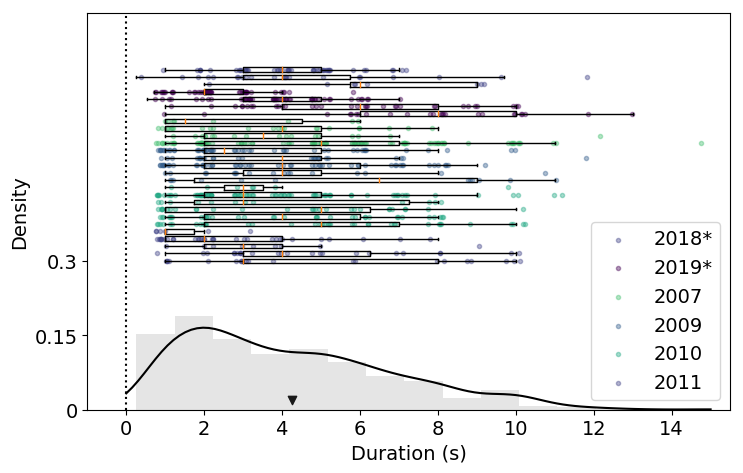

In [525]:
## Build and Plot Figure 6a Durations figure for all birds 
# Durations_df2 was built in Fig5 data processing above

#durations_df = pd.read_csv('./durations_df2.csv')

print(pd.unique(durations_df['AvgPotency']))
aviary_dict = dict(zip(pd.unique(durations_df['Aviary']),range(len(pd.unique(durations_df['Aviary'])))))
aviary_colors = paper_cmap([0.2,0.0,0.7,.3,.6,.2])

fig,ax = plt.subplots()
duration_list_all = []
duration_list_flat = []
mean_durations = []
aviary_list = []

for b_i,b in enumerate(pd.unique(durations_df['Bird'])):
    #ax.hist(durations_df.loc[durations_df['Bird'] == b]['Duration'],alpha=.5)
    one_bird_df = durations_df.loc[durations_df['Bird'] == b]
    if len(one_bird_df) < 5 or np.nanmean(one_bird_df['ResponseRate']) < .05:
        #print(b)
        continue
    duration_list_all.append(durations_df.loc[durations_df['Bird'] == b]['Duration'])
    duration_list_flat.extend(durations_df.loc[durations_df['Bird'] == b]['Duration'])
    aviary_list.append(aviary_dict[one_bird_df['Aviary'].iloc[0]])
    mean_durations.append(np.mean(duration_list_all[-1]))

running_count = 0
block_sort = []
for i in range(max(aviary_list)+1):
    subset = np.array(mean_durations)[np.array(aviary_list) == i]

    sub_order = np.argsort(subset) + running_count
    block_sort.extend(sub_order)
    running_count += len(subset)

#duration_list_all = [duration_list_all[i] for i in np.argsort(mean_durations)[::-1]]
duration_list_all = [duration_list_all[i] for i in block_sort]
pos_ys = np.arange(.3,.7,.4/len(duration_list_all))[::-1]

aviaries_plotted = []
aviary_plot_list = ['2018*','2019*','2007','2009','2010','2011']
for b in range(len(duration_list_all)):
    aviary_i = aviary_list[b]

    jitter_dur = (np.random.rand(len(duration_list_all[b])) - .5) * .5
    ax.scatter(duration_list_all[b] + jitter_dur,[pos_ys[b]] * len(duration_list_all[b]),
               alpha=.4,marker='.',color=aviary_colors[aviary_list[b]],label=aviary_plot_list[aviary_i] if aviary_i not in aviaries_plotted else "")
    aviaries_plotted.append(aviary_i)
ax.boxplot(duration_list_all,positions=pos_ys,widths=[.25/len(duration_list_all)] * len(duration_list_all),vert=False,showfliers=False)
ax.hist(duration_list_flat,normed=True,bins=int(max(duration_list_flat)),color='gray',alpha=.2)
ax.scatter(np.mean(duration_list_flat),.02,marker='v',color='black')

dur_density = gaussian_kde(duration_list_flat)
dur_xs = np.linspace(0,15,100)
ax.legend(loc='lower right')
ax.plot(dur_xs,dur_density(dur_xs),color='black')
#ax.get_yaxis().set_visible(False)
ax.set_yticks((0,.15,.3))
ax.set_yticklabels([0,.15,.3])
#ax2.boxplot(bird_durations,positions=dur_heights,vert=False,widths=dur_widths,showfliers=False)    
ax.set_ylim(0,0.8)
ax.axvline(0,linestyle=':',color='black')
ax.set_xlim(-1,15.5)
ax.set_ylabel('Density')
ax.set_xlabel('Duration (s)')

fig.tight_layout()
fig.set_size_inches(8,5)

if True:
    fig.savefig('./figures/6a_full.png',dpi=300)
    fig.savefig('./figures/6a_full.svg')

fig.show()

In [600]:
print(f_oneway(*duration_list_all))
print(len(duration_list_flat))
print('Mean, std:',np.nanmean(duration_list_flat),np.nanstd(duration_list_flat))

res2 = pairwise_tukeyhsd(durations_df['Duration'],durations_df['Bird'])
if verbose:
    print("summary:", res2.summary())
    p_values = psturng(np.abs(res2.meandiffs / res2.std_pairs), len(res2.groupsunique), res2.df_total)
    print()
    print("p values:", p_values)

print(levene(*duration_list_all))
print(len(duration_list_all))

F_onewayResult(statistic=5.996034304358168, pvalue=2.0358595399795086e-18)
832
Mean, std: 4.250223557536419 2.6673121945118194
LeveneResult(statistic=4.179653915978103, pvalue=3.42183261563058e-11)
27


['Y1', 'CB-Orange', 'PINK2', 'CB-Y2', 'CB-LB2', 'CB-Yellow', 'P1']
neg latencies: 0
Latencies: 0.6910900911984142 0.29270161360620767 222
Median Latency: 0.6829999246597285
Durations: 4.513791109720866 2.461010592176569 225


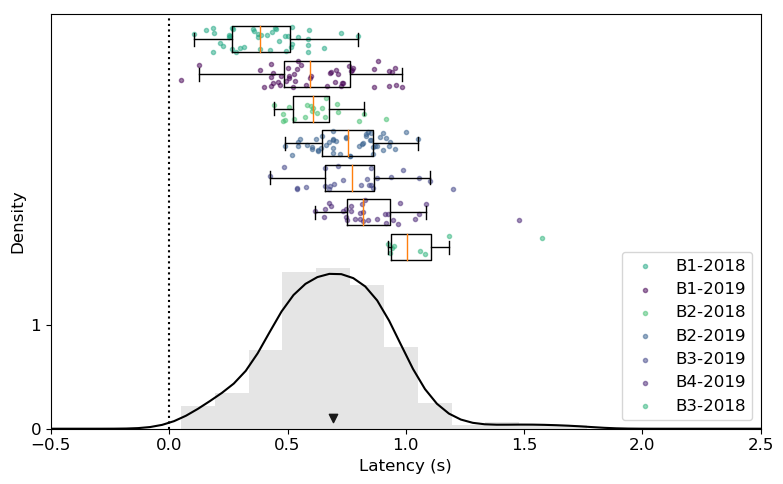

In [647]:
## Make data and plot figure 7a, Get durations,latencies by bird: 
song_list = ['BDY','BOD','ND','LB','2M','DBR','GRG','WG','LNR','DMG']
plot_bird_list = ['Y1','CB-Orange','PINK2','CB-Y2','CB-LB2','CB-Yellow','P1']
simple_bird_list = ['B1-2018','B1-2019','B2-2018','B2-2019','B3-2019','B4-2019','B3-2018']
plot_bird_indices = [1,2,5,7,8,9,4]

bird_color_values = [0.6,0.0,0.7,.3,.2,.1,.65,0,0,0]
bird_colors = [paper_cmap(v) for v in bird_color_values]
base_h = 1.75
top_h = 3.75

print(plot_bird_list)
n_birds = len(plot_bird_list)


durations = np.array(data_array[:,:,:,2])

durations[data_key[:,:,:,2] == 0] = np.nan
durations[data_array[:,:,:,0] != 1] = np.nan
good_durations = durations[~np.isnan(durations)]

latencies = np.array(data_array[:,:,:,1])
latencies[data_key[:,:,:,2] == 0] = np.nan
latencies[data_array[:,:,:,0] != 1] = np.nan
good_latencies = latencies[~np.isnan(latencies)]
print('neg latencies:',np.sum(good_latencies <= 0))
good_latencies = good_latencies[good_latencies > 0]

bird_durations = [np.nan] * n_birds
bird_latencies = [np.nan] * n_birds

## Get durations and latencies by bird
for i in range(n_birds):
    bird_name = plot_bird_list[i]
    n = bird_dict[bird_name]
    p_indices = np.logical_and(~np.isnan(data_array[n,:,:,2]),data_array[n,:,:,0] == 1)
    crap_indices = data_key[n,:,:,2] == 0
    bird_durations[i] = data_array[n,:,:,2][np.logical_and(p_indices,~crap_indices)]

    bird_latencies[i] = data_array[n,:,:,1][np.logical_and(p_indices,~crap_indices)]
    
    bird_durations[i] = bird_durations[i][~np.isnan(bird_latencies[i])]
    bird_latencies[i] = bird_latencies[i][~np.isnan(bird_latencies[i])]
#print('****',bird_latencies)
#print('**',bird_durations)

#fig,(ax1,ax2) = plt.subplots(1,2)
fig,ax1 = plt.subplots()

## base_h defined above
dur_heights = np.linspace(base_h,top_h,n_birds)[::-1]
lat_heights = np.linspace(base_h,top_h,n_birds)[::-1]
dur_widths = [.25] * n_birds

for s in range(n_birds):
    i = plot_bird_indices[s]
    ys_dur = np.array([dur_heights[s]] * len(bird_durations[s]))
    ys_lat = np.array([lat_heights[s]] * len(bird_durations[s]))
                      
    jitter_dur = (np.random.rand(len(ys_dur)) - .5) * .25
    jitter_lat = (np.random.rand(len(ys_lat)) - .5) * .25

    ys_dur = ys_dur + jitter_dur
    ys_lat = ys_lat + jitter_lat
    ax2.scatter(bird_durations[s],ys_dur,alpha=.5,marker='.',color=bird_colors[s])
    ax1.scatter(bird_latencies[s],ys_lat,alpha=.5,marker='.',color=bird_colors[s],label=simple_bird_list[s])

    mark_h = .5
    #ax1.scatter(np.nanmean(bird_latencies[s]),mark_h,marker='v',color=bird_colors[i])
    #ax2.scatter(np.nanmean(bird_durations[s]),mark_h,marker='v',color=bird_colors[i])


#ax2.boxplot(bird_durations,positions=dur_heights,vert=False,widths=dur_widths,showfliers=False)
#print(lat_heights)
#print(bird_latencies)
ax1.boxplot(bird_latencies,positions=lat_heights,vert=False,widths=dur_widths,showfliers=False)

dur_xs = np.linspace(-5,25,100)    
lat_xs = np.linspace(-2,3,100)
#ax1.scatter(np.nanmean(good_latencies),mark_h *3,marker='v',color='red',s=60)
#ax2.scatter(np.nanmean(good_durations),mark_h *3,marker='v',color='red',s=60)

ax1.hist(good_latencies,bins=20,color='gray',alpha=.2,normed=True)
#ax2.hist(good_durations,bins=10,color='gray',alpha=.2,normed=True)

ax1.scatter(np.mean(good_latencies),.1,marker='v',color='black')
lat_curve =  gaussian_kde(good_latencies)

ax1.plot(lat_xs,lat_curve(lat_xs),color='black')
"""
for b in range(n_birds):
    #y,x,_ = plt.hist(bird_durations[b],bins=10,alpha=.2)
    #lat_y,lat_x,_ = plt.hist(bird_latencies[b],bins=20,alpha=.2)
    i = plot_bird_indices[b]
    if len(bird_latencies[b]) > 1:
        dur_curve = gaussian_kde(bird_durations[b],bw_method=.3)
        #ax2.plot(dur_xs,dur_curve(dur_xs) * max(y) / max(dur_curve(dur_xs)),color=bird_colors[i],label=plot_bird_list[b])
        lat_curve = gaussian_kde(bird_latencies[b],bw_method=.3)
        #ax1.plot(lat_xs,lat_curve(lat_xs) * max(lat_y) / max(lat_curve(lat_xs)),color=bird_colors[i])
"""
ax1.set_xlim([-.5,2.5])       
ax1.set_ylim([0,4.0])  



ax1.set_yticks(np.arange(0,2))
ax1.set_yticklabels([0,1])
#ax1.set_yticklabels(np.arange(0,10))
"""
ax2.set_xlim([-1,15])
ax2.set_ylim(0,4)
ax2.set_yticks(np.arange(0,2))
ax2.set_yticklabels([0,1])
ax2.set_ylabel('   ')
ax2.set_xlabel('Duration (s)')
ax2.axvline(0,linestyle=':',color='black')
"""
ax1.set_ylabel('Density')

ax1.set_xlabel('Latency (s)')

ax1.axvline(0,linestyle=':',color='black')

#fig.legend()

ax1.legend(loc='lower right')
#fig.set_size_inches(10,5)
fig.set_size_inches(8,5)
fig.tight_layout()
fig.show()


print('Latencies:',np.mean(good_latencies),np.std(good_latencies),len(good_latencies))
print('Median Latency:',np.median(good_latencies))
print('Durations:',np.mean(good_durations),np.std(good_durations),len(good_durations))

if True:
    fig.savefig('./figures/7a.png',dpi=300)
    fig.savefig('./figures/7a.svg')

In [584]:
##Test for whether birds are different. 

from statsmodels.stats.libqsturng import psturng

lats = []
durs = []
bird_ids = []
if verbose:
    print('mean values: (latency +-std, duration +-std)')
for b in range(len(bird_latencies)):
    if verbose:
        print(b,np.nanmean(bird_latencies[b]),np.nanstd(bird_latencies[b]),np.nanmean(bird_durations[b]),np.nanstd(bird_durations[b]))
    lats.extend(bird_latencies[b])
    durs.extend(bird_durations[b])
    bird_ids.extend([b] * len(bird_latencies[b]))
    
print('\nSignificant variation in latency (std is similar)')

print(f_oneway(*bird_latencies))
res2 = pairwise_tukeyhsd(lats,bird_ids)
print("summary:", res2.summary())
p_values = psturng(np.abs(res2.meandiffs / res2.std_pairs), len(res2.groupsunique), res2.df_total)
print()
print("p values:", p_values)

#print(pairwise_tukeyhsd(lats,bird_ids))
print(levene(*bird_latencies))

print('\n\nSignificant variation in duration ')
print(f_oneway(*bird_durations))
res2 = pairwise_tukeyhsd(durs,bird_ids)
print("summary:", res2.summary())
p_values = psturng(np.abs(res2.meandiffs / res2.std_pairs), len(res2.groupsunique), res2.df_total)
print()
print("p values:", p_values)

print(levene(*bird_durations))




mean values: (latency +-std, duration +-std)

Significant variation in latency (std is similar)
F_onewayResult(statistic=24.10656175516873, pvalue=1.0516890817392648e-21)
summary: Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     0.2249   0.085  0.3648  True 
  0      2     0.2249   0.0459 0.4038  True 
  0      3     0.3584   0.2192 0.4976  True 
  0      4     0.3777   0.2091 0.5463  True 
  0      5     0.519    0.363  0.675   True 
  0      6     0.6832   0.4291 0.9373  True 
  1      2      -0.0   -0.1759 0.1758 False 
  1      3     0.1335  -0.0017 0.2687 False 
  1      4     0.1528  -0.0125 0.3181 False 
  1      5     0.2941   0.1417 0.4466  True 
  1      6     0.4583   0.2063 0.7103  True 
  2      3     0.1335  -0.0418 0.3089 False 
  2      4     0.1528  -0.0466 0.3523 False 
  2      5     0.2942   0.1052 0.4831  True 
  2      6     0.4583   0.1828 0.7339  True 
  3 

In [479]:
## Set some values, from the Pymer code.
#intercept_l,effect_l,variance_l =  mdf_lat.params
intercept_l,effect_l = 0.960,-0.228 # effect estimates of potency on latency
il_low,il_high = 0.737,1.183  #95% confidence interval of latency intercept
el_low,el_high = -0.394,-0.040 #95% confidence interval of potency effect on latency

## Pulled from full duration set
#intercept_d,effect_d,variance_d =  mdf_dur.params
intercept_d,effect_d = 2.407,2.539 # Effect estimates of potency on duration
id_low,id_high = 1.461,3.353 #95% confidence interval of intercept
ed_low,ed_high = 0.816,4.262 #95% confidence interval of potency effect on duration

dur_line = np.poly1d([effect_d,intercept_d])
low_dur = np.poly1d([ed_low,id_low])
high_dur = np.poly1d([ed_high,id_high])

lat_line = np.poly1d([effect_l,intercept_l])
low_lat = np.poly1d([el_low,il_low])
high_lat = np.poly1d([el_high,il_high])


In [476]:
## Build posture_df to do duration latency mixed linear regression for birdview birds
old_df = pd.read_csv('./DataManuscript/presentation_info.csv')

file_list = good_list
seq_dir = dir_list[0]

binary_array = birdview_binary
binary_array[binary_array[:,:,:,0] == 2] = 0

song_list = birdview_meta.song_list
bird_list = birdview_meta.bird_list
posture_df = pd.DataFrame(columns=['Bird','Song','Block','RelPotency','AvgPotency','Latency',
                            'Duration','AutoLatency','AutoDuration','Year','ResponseRate'],index=range(213))
song_list_i = range(len(song_list))
bird_list_i = range(len(bird_list))

responsive_birds_2019 = np.nanmean(bv2019_binary[:,:,:,0],axis=(1,2)) > .05
responsive_birds_2018 = np.nanmean(bv2018_binary[:,:,:,0],axis=(1,2)) > .05
print(responsive_birds_2019,responsive_birds_2018)
song_potency_2019 = dict(zip(song_list,np.nanmean(bv2019_binary[responsive_birds_2019,:,:,0],axis=(0,1))))
song_potency_2018 = dict(zip(song_list,np.nanmean(bv2018_binary[responsive_birds_2018,:,:,0],axis=(0,1))))

relative_potency = {}
for b in range(len(bird_list)):
    relative_potency[bird_list[b]] = dict(zip(song_list,np.nanmean(binary_array[b,:,:,0],axis=0)))

count = 0
for s in file_list:

    seq = pickle.load(open(seq_dir + s,'rb'))
    if seq.offset == 0 or seq.posture != 1:
        continue
    if not seq.clean:
        #print('skipping',seq.seq_name)
        pass
        #continue
        
    if seq.bird not in bird_list:
        continue
    manual_row = test_3[test_3['SeqName'] == seq.seq_name]
    old_row = old_df[old_df['SeqName'] == seq.seq_name]
    #print(manual_row['Posture'].item())
    if manual_row['Posture'].item() != 1:
        #print('I caught one!')
        continue

    if '2018' in seq.seq_name:
        if '-' in seq.song:
            continue
        year = 2018
        true_duration = manual_row['PostureDuration'].item()
        true_latency = manual_row['PostureStamp'].item() + seq.ts[0]
        song_potency = song_potency_2018

    else:
        year = 2019
        song_potency = song_potency_2019
        true_duration = old_row['PostureDuration'].item()
        if true_duration == 'R':
            continue
        true_latency = old_row['PostureStamp'].item() + seq.ts[0]
    if seq.t_latency_index == 0:
        auto_latency = np.nan
        auto_duration = np.nan
    else:
        auto_latency = seq.t_latency
        auto_duration = seq.duration
    #print(true_duration,true_latency)
    #print(true_duration,true_latency)

    posture_df.loc[count] = [bird_dict[seq.bird],song_dict[seq.song],seq.block,
                             relative_potency[seq.bird][seq.song],song_potency[seq.song],
                             true_latency,true_duration,auto_latency,auto_duration,year,0.0]
    count += 1

for i,row in posture_df.iterrows():
    bird = row['Bird']
    block = row['Block']
    bird_df = posture_df[posture_df['Bird'] == bird]
    bird_row_df = bird_df[bird_df['Block'] == block]
    
    #print(row)
    #print(bird,block)
    
    response_rate = np.nanmean(birdview_binary[int(bird),int(block),:,0])
    #print(response_rate,i)
    #row['ResponseRate'] = response_rate
    #posture_df.iat[i,7] = response_rate
    posture_df.set_value(i,'ResponseRate',response_rate)
    posture_df.iat[i,-1] = response_rate
    #print('change?',posture_df.iat[i,-1])
    #print(posture_df.iloc[i])

posture_df.infer_objects()
if True:
    posture_df.to_csv('./posture_df5.csv')
pass

[ True  True  True False  True  True False] [ True  True  True]


['CB-White', 'CB-Orange', 'CB-Yellow', 'CB-Red', 'CB-LB2', 'CB-Y2', 'CB-R2', 'P1', 'Y1', 'PINK2']
['CB-Orange', 'CB-Yellow', 'CB-Y2', 'P1', 'Y1', 'PINK2', 'CB-LB2']


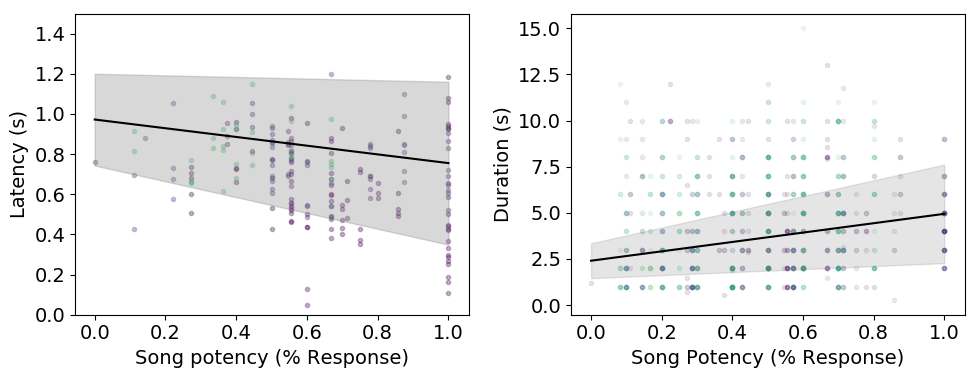

In [521]:
## Plot with Respect to Song Potency (Figures 6b & 7b)

trimmed_df = posture_df[['AutoLatency','RelPotency','Bird']].dropna()
trimmed_df = posture_df.dropna(subset=['Latency','Duration','ResponseRate','RelPotency','Bird','Song','Year'])
trimmed_df = trimmed_df.reset_index(drop=True)
trimmed_df = posture_df
trimmed_df.infer_objects()

fig,(ax,ax1) = plt.subplots(1,2)
bird_list = birdview_meta.bird_list
song_list = birdview_meta.song_list
print(bird_list)
#birds_to_plot = [1,2,4,5,6,7,8,9]
birds_to_plot = [1,2,5,7,8,9,4]
print([bird_list[i] for i in birds_to_plot])
xs_bird_all, ys_bird_all,ys_lat_bird_all = [],[],[]
label_birds_all,label_songs_all = [],[]
for f in birds_to_plot:
    bird_df = trimmed_df[trimmed_df['Bird'] == f]
    xs = np.array(bird_df['RelPotency']).astype(float)
    ys = np.array(bird_df['Duration']).astype(float)
    xs_resp = np.array(bird_df['ResponseRate']).astype(float)
    xs_lat = np.array(bird_df['RelPotency']).astype(float)
    ys_lat = np.array(bird_df['Latency']).astype(float)

    #xs = xs[~np.isnan(ys)]
    #ys = ys[~np.isnan(ys)]
    #xs_lat = xs_lat[~np.isnan(ys_lat)]
    #ys_lat = ys_lat[~np.isnan(ys_lat)]
    #ax1.scatter(xs,ys,marker='.',alpha=.5,color=bird_colors[f])
    ax.scatter(xs_lat,ys_lat,marker='.',alpha=.3,color=bird_colors[f])
    if len(xs) > 0:
        fit_line = np.poly1d(np.polyfit(xs,ys,1))
        #ax1.plot([0,1],fit_line([0,1]),linestyle=':',label='Bird ' + str(f),color=bird_colors[f])
        
    if len(xs_lat) > 0:
        fit_line = np.poly1d(np.polyfit(xs_lat,ys_lat,1))
        #ax.plot([0,1],fit_line([0,1]),linestyle=':',color=bird_colors[f])
    xs_bird, ys_bird,ys_lat_bird = [],[],[]
    resp_bird = []
    label_birds,label_songs = [],[]
    for song in song_list:
        s = birdview_meta.song_dict[song]
        #print(bird_df['Song'])
        bird_song = bird_df[bird_df['Song'] == s]
        if len(bird_song) > 0:
            mean_song_duration = np.nanmean(np.array(bird_song['Duration']).astype(float))
            mean_song_latency = np.nanmean(np.array(bird_song['Latency']).astype(float))
            song_potency = bird_song['RelPotency'].iloc[0]
            block_response = bird_song['ResponseRate'].iloc[0]
            xs_bird.append(song_potency)
            ys_bird.append(mean_song_duration)
            resp_bird.append(block_response)
            ys_lat_bird.append(mean_song_latency)
            label_birds.append(f)
            label_songs.append(s)
    #print('Duration:',pearsonr(xs_bird,ys_bird))
    #print('Latency:',pearsonr(xs_bird,ys_lat_bird))
    #print('ResponseRate & Duration:',pearsonr(resp_bird,ys_bird))
    #print('ResponseRate & Latency:',pearsonr(resp_bird,ys_lat_bird))
    xs_bird_all.extend(xs_bird)
    ys_bird_all.extend(ys_bird)
    ys_lat_bird_all.extend(ys_lat_bird)
    label_birds_all.extend(label_birds)
    label_songs_all.extend(label_songs)
        
    # I'm plotting duration with respect to relative potency

all_bird_list = pd.unique(durations_df['Bird'])
n_all_birds = len(all_bird_list)

for b in range(n_all_birds):
    bird_df = durations_df[durations_df['Bird'] == all_bird_list[b]]
    aviary = bird_df['Aviary'].iloc[0]
    aviary_i = aviary_dict[aviary]
    #color = paper_cmap(b/n_all_birds)
    color = aviary_colors[aviary_i]
    ax1.scatter(bird_df['RelPotency'],bird_df['Duration'],marker='.',alpha = .1,color=color,label=cm.viridis(b/n_all_birds))
    fit_line = np.poly1d(np.polyfit(bird_df['AvgPotency'],bird_df['Duration'],1))
    #ax1.plot([0,1],fit_line([0,1]),linestyle=':',label='Bird ' + str(f),color=bird_colors[f])
    #ax1.text(1,fit_line(1),str(b))


ax1.plot([0,1],dur_line([0,1]),color='black')
ax1.fill_between([0,1],high_dur([0,1]),low_dur([0,1]),color='gray',alpha=.2)

ax1.set_ylabel('Duration (s)')
ax1.set_xlabel('Song Potency (% Response)')    
    
    
ax.plot([0,1],lat_line([0,1]),color='black')
#ax.plot([0,1],low_lat([0,1]),color='black')
#ax.plot([0,1],high_lat([0,1]),color='black')
ax.fill_between([0,1],high_lat([0,1]),low_lat([0,1]),color='gray',alpha=.3)

#ax1.plot([0,1],dur_line([0,1]),color='black')
#ax1.plot([0,1],low_dur([0,1]),color='black')
#ax1.plot([0,1],high_dur([0,1]),color='black')
#ax1.fill_between([0,1],high_dur([0,1]),low_dur([0,1]),color='gray',alpha=.3)

ax.set_xlabel('Song potency (% Response)')
ax.set_ylabel('Latency (s)')
ax.set_ylim([0,1.5])
ax.set_yticks(np.arange(0,1.5,.2))
ax.set_xticks(np.arange(0,1.1,.2))

#ax1.set_xlabel('Song Potency')
#ax1.set_ylabel('Duration (s)')
#fig.legend()
fig.set_size_inches([10,4])

fig.tight_layout()
if True:
    fig.savefig('./figures/fig67b.png',dpi=300)
fig.show()

27


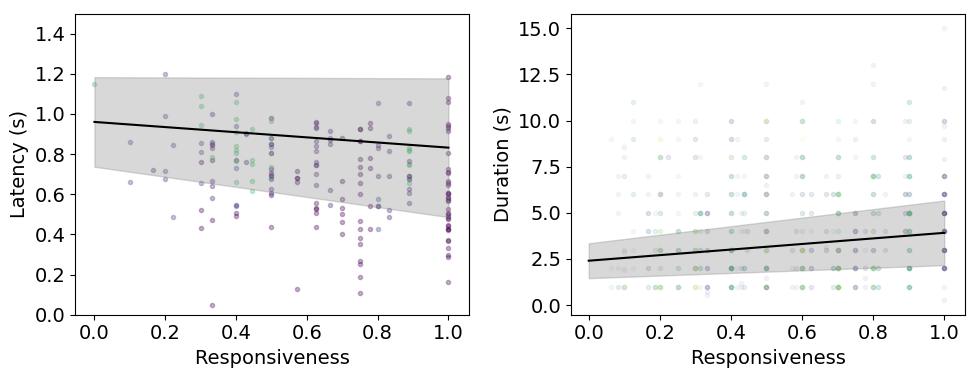

In [524]:
## Plot with respect to response rate (Figures 6c & 7c)

intercept_l,effect_lr = 0.960,-0.128 #the estimated intercept and effect size of resp. rate on latency
il_low,il_high = 0.737,1.183  #95% confidence interval of latency intercept
elr_low,elr_high = -0.251,-0.006 #95% confidence interval of response rate on latency

## Pulled from full duration set
#intercept_d,effect_d,variance_d =  mdf_dur.params
intercept_d,effect_dr = 2.407,1.510
id_low,id_high = 1.461,3.353
edr_low,edr_high = 0.706,2.314

dur_line_r = np.poly1d([effect_dr,intercept_d])
low_dur_r = np.poly1d([edr_low,id_low])
high_dur_r = np.poly1d([edr_high,id_high])

lat_line_r = np.poly1d([effect_lr,intercept_l])
low_lat_r = np.poly1d([elr_low,il_low])
high_lat_r = np.poly1d([elr_high,il_high])

fig,(ax,ax1) = plt.subplots(1,2)

## Plot Duration by individual
print(n_all_birds)
for b in range(n_all_birds):
    bird_df = durations_df[durations_df['Bird'] == all_bird_list[b]]
    aviary = bird_df['Aviary'].iloc[0]
    aviary_i = aviary_dict[aviary]
    #color = paper_cmap(b/n_all_birds)
    #color = aviary_colors[aviary_i]
    color = cm.viridis(b/n_all_birds)
    ax1.scatter(bird_df['ResponseRate'],bird_df['Duration'],marker='.',alpha = .05,color=color,label=aviary)
    if False:
        if len(bird_df['Duration']) > 1:
            #print('drawing',f)
            fit_line = np.poly1d(np.polyfit(bird_df['ResponseRate'],bird_df['Duration'],1))
            #print(fit_line([0,1]))
            ax1.plot([0,1],fit_line([0,1]),alpha=.5,color=cm.viridis(b/n_all_birds))
        else:
            #print('skipping',f)
            pass
    
## Plot latency by individual

birds_to_plot = [1,2,4,5,6,7,8,9]
for f in birds_to_plot:
    bird_df = trimmed_df[trimmed_df['Bird'] == f]
    bird_df = bird_df.dropna(subset=['Latency','ResponseRate'])
    xs_resp = np.array(bird_df['ResponseRate']).astype(float)
    ys_lat = np.array(bird_df['Latency']).astype(float)

    ax.scatter(xs_resp,ys_lat,marker='.',alpha=.3,color=bird_colors[f])
    if False:
        if len(ys_lat) > 5:
            #print('drawing',f)
            fit_line = np.poly1d(np.polyfit(xs_resp,ys_lat,1))
            #print(fit_line([0,1]))
            ax.plot([0,1],fit_line([0,1]),alpha=.5,color=bird_colors[f])
        else:
            #print('skipping',f)
            pass


ax.plot([0,1],lat_line_r([0,1]),color='black')
ax.fill_between([0,1],high_lat_r([0,1]),low_lat_r([0,1]),color='gray',alpha=.3)   
    
    
ax1.plot([0,1],dur_line_r([0,1]),color='black')
ax1.fill_between([0,1],high_dur_r([0,1]),low_dur_r([0,1]),color='gray',alpha=.3)

ax.set_ylim([0,1.5])
ax.set_xlabel('Responsiveness')
ax.set_ylabel('Latency (s)')
ax1.set_ylabel('Duration (s)')
ax1.set_xlabel('Responsiveness')

ax.set_yticks(np.arange(0,1.5,.2))
ax.set_xticks(np.arange(0,1.1,.2))
ax1.set_yticks(np.arange(0,15.1,2.5))
#ax1.set_ylim([0,14])


#fig.legend()

fig.set_size_inches([10,4])

fig.tight_layout()

fig.show()

if True:
    fig.savefig('./figures/fig67c.png',dpi=300)


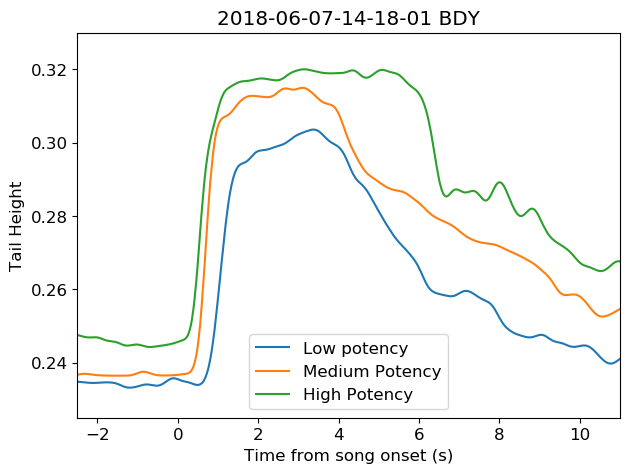

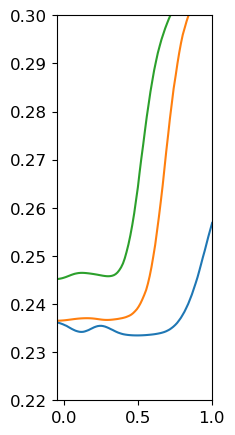

In [41]:
## Plot exemplar postures (Figure 7d)

# Some attempts at good exemplars
#exemplars = ['2019-06-10-11-46-12_ND','2019-06-18-08-46-14_2M','2019-06-18-17-16-14_WG']
#exemplars = ['2018-06-08-08-18-01','2018-05-30-12-48-01','2018-06-01-12-48-01']
from scipy.ndimage import gaussian_filter1d


exemplars = ['2019-06-18-15-32-52_GRG','2019-06-12-13-16-14_BDY','2019-06-13-15-32-53_LB',
             ]
exemplars = ['2018-05-30-11-17-56','2018-06-07-14-18-01','2018-05-31-15-48-05']
labels = ['Low potency','High Potency','Medium Potency']
label_dict = dict(zip(exemplars,labels))
fig,ax = plt.subplots()
fig1,ax1 = plt.subplots()
for i,row in test_3.iterrows():
    if '2018' not in row['SeqName']:# and '2018' not in row['SeqName']:
        continue
    ## Need the seq for offset, if it doesn't exist just count it but no time
    try:
        seq = pickle.load(open('./SeqClasses/' + row['SeqName'] + '.obj','rb'))
    except:
        continue
       
    if seq.posture and seq.clean:
        if len(seq.ts) != seq.smooth_data.shape[0]:
            continue
        if seq.ts[0] == 0:
            continue
        if seq.seq_name not in exemplars:
            pass
            continue
        #fig,ax = plt.subplots()
        extra_smooth = gaussian_filter1d(seq.smooth_data[:,10,2],sigma=10)
        foot_height = (seq.smooth_data[:,12,2] + seq.smooth_data[:,11,2]) / 2
        #extra_smooth = seq.smooth_data[:,10,2]
        #ax.plot(seq.ts,extra_smooth)
        #ax.plot(seq.ts,seq.rough_data[:,10,2],alpha=.2,color='gray')
        ax.plot(seq.ts,extra_smooth,label=label_dict[seq.seq_name])
        if False:
            ax.plot(seq.ts,foot_height,label=label_dict[seq.seq_name] + '_foot')
        #ax.plot(seq.ts,)
        #ax1.plot(seq.ts,seq.rough_data[:,10,2],alpha=.2,color='gray')
        ax1.plot(seq.ts,seq.smooth_data[:,10,2])
        #ax1.plot(seq.ts,extra_smooth)
        if verbose:
            print(seq.ts[0])
            print(row['PostureStamp'])
            print(seq.bird)
            print('latency',row['PostureStamp'] + seq.ts[0])
        ax.set_xlim([-.5,10])
        ax.set_title(seq.seq_name + ' ' + seq.song)
        #fig.savefig('./PlottedPostures/' + seq.seq_name + '_' + seq.song + '.png',dpi=300)

        #fig.show()
if True:
    ax.set_xlim([-2.5,11])
    ax.set_ylim([0.225,0.33])
    ax1.set_xlim([-0.05,1])
    ax1.set_ylim([0.22,0.30])

    ax.set_ylabel('Tail Height')
    ax.set_xlabel('Time from song onset (s)')

    ax.legend()
    #fig.legend()
    fig.set_size_inches([7,5])
    fig.show()
    fig1.set_size_inches([2,5])
    fig1.show()
    if False:
        fig.savefig('./figures/ExemplarFiga.png',dpi=300)
        fig1.savefig('./figures/ExemplarFigb.png',dpi=300)
        fig.savefig('./figures/ExemplarFiga.svg')
        fig1.savefig('./figures/ExemplarFigb.svg')


In [651]:
block0_df = posture_df[posture_df['Block'] == 0]
print('Mean first block:',np.nanmean(block0_df['Latency']))
print('Std first block:',np.nanstd(block0_df['Latency']))

Mean first block: 0.8232353566113642
Std first block: 0.3191275589570672


### Figure 8:
What other behaviors do females produce in response to song? 

45
Depuff : 37 37 0.13456756705206802 0.02212283605259577 47 0.06283422459893048
36
Wingstroke : 30 30 0.0059666748682657795 0.15948428686481833 41 0.05481283422459893
247
CSD : 237 237 0.6680970473148651 0.014884962224797066 280 0.37433155080213903
50
Partial-CSD : 28 28 1.1095714353833879 0.03956427408053568 55 0.07352941176470588
748
Startle 16 0.0213903743315508
Depuff 47 0.06283422459893048
Wingstroke 41 0.05481283422459893
CSD 280 0.37433155080213903
Partial-CSD 55 0.07352941176470588
Look Around 38 0.05080213903743316
Leg Adjustment 26 0.034759358288770054
Other/None 0 0.0
Poop 3 0.004010695187165776


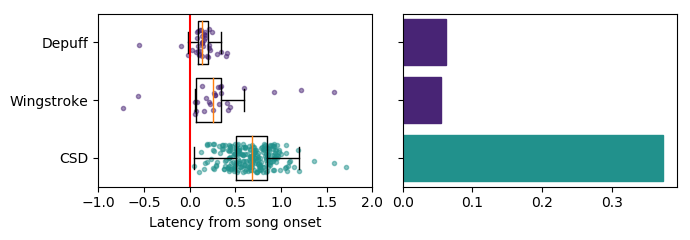

In [658]:
## Calculate some stuff and Plot Figure 8b
plt.style.use('default')
fig,(ax,ax1) = plt.subplots(1,2,sharey=True)
paper_cmap = cm.viridis
good_labels = ['Depuff','Wingstroke','CSD','Partial-CSD']
color_values = [.1,.1,.5,.7]
group_colors = [paper_cmap(c) for c in color_values]
anova_data = []
tukey_data = []
tukey_labels = []
for l in range(len(good_labels)):
    label = good_labels[l]
    xs = np.array(latency_dict[label])
    print(len(xs))
    xs = xs[~np.isnan(xs)]
    anova_data.append(xs)

    ys = [len(good_labels) - l] * len(xs)
    tukey_data.extend(xs)
    tukey_labels.extend(ys)
    jitter = np.random.rand(len(xs)) - .5 
    ys = np.array(ys) + jitter * .5
    ax.scatter(xs,ys,alpha=.5,marker='.',color=group_colors[l])
    ax.boxplot(xs,positions=[len(good_labels) - l],vert=False,showfliers=False,widths=[.75])
    print(label,':',len(xs),np.sum(~np.isnan(xs)),np.nanmean(xs),np.nanstd(xs) / np.sqrt(count_dict[label]),count_dict[label],count_dict[label] / total_count)
ax.axvline(0,color='red')
ax.set_yticks(range(1,len(good_labels)+1))
ax.set_yticklabels(good_labels[::-1])

ax.set_xlabel('Latency from song onset')
ax.set_xlim([-1,2.0])
ax.set_ylim([1.5,4.5])

print(total_count)
bars = ax1.barh([1,2,3,4],[count_dict[l] / total_count for l in good_labels[::-1]])
for b in range(len(bars)):
    bars[b].set_color(group_colors[::-1][b])
#ax1.set_xlim([0,1])

fig.set_size_inches(7,2.5)
fig.tight_layout()
fig.show()
fig.savefig('./figures/Fig8b')

for k in count_dict.keys():
    print(k,count_dict[k],count_dict[k]/total_count)
    
    
    

In [664]:
## Build and perform some stats
print('CSD Latency:')
print(np.nanmean(latency_dict['CSD']))
print(np.nanstd(latency_dict['CSD']))
print(np.sum(~np.isnan(latency_dict['CSD'])))
print('SEM:',np.nanstd(latency_dict['CSD'])/np.sqrt(np.sum(~np.isnan(latency_dict['CSD']))))

print('Wingstrokes:')
ws_latency_array = np.array(latency_dict['Wingstroke'])
ws_bird_array = np.array(wingstroke_birds)
ws_bird_array = ws_bird_array[~np.isnan(ws_latency_array)]
ws_latency_array = ws_latency_array[~np.isnan(ws_latency_array)]

dp_latency_array = np.array(latency_dict['Depuff'])
dp_bird_array = np.array(depuff_birds)
dp_bird_array = dp_bird_array[~np.isnan(dp_latency_array)]
dp_latency_array = dp_latency_array[~np.isnan(dp_latency_array)]

pre_counts,post_counts = [],[]

for b in np.unique(ws_bird_array):
    ws_latency_bird = ws_latency_array[ws_bird_array == b]
    pre_counts.append(np.sum((ws_latency_bird <= 0) & (ws_latency_bird >-1)))
    post_counts.append(np.sum((ws_latency_bird > 0) & (ws_latency_bird < 1)))

print('n=',len(ws_latency_array))
print('n > 0',len(ws_latency_array[ws_latency_array>0]))
print('Mean,std:',np.mean(ws_latency_array[ws_latency_array>0]),np.std(ws_latency_array[ws_latency_array>0]))
print('SEM:',np.std(ws_latency_array[ws_latency_array>0] / np.sqrt(np.sum(ws_latency_array>0))))
#print(ttest_ind(pre_counts,post_counts))
print(pre_counts,post_counts)
print(np.sum(np.array(latency_dict['Wingstroke'])<=0))
print(np.sum(~np.isnan(np.array(latency_dict['Wingstroke']))))
print(len(wingstroke_birds),len(latency_dict['Wingstroke']))
print(5/30)

print('Depuffs')

pre_counts,post_counts = [],[]
for b in np.unique(ws_bird_array):
    dp_latency_bird = dp_latency_array[dp_bird_array == b]
    pre_counts.append(np.sum((dp_latency_bird <= 0) & (dp_latency_bird >-1)))
    post_counts.append(np.sum((dp_latency_bird > 0) & (dp_latency_bird < 1)))

print('n:',len(dp_latency_array))
print('n real:',len(dp_latency_array[dp_latency_array>0]))
print('Mean,std:',np.mean(dp_latency_array[dp_latency_array>0]),np.std(dp_latency_array[dp_latency_array>0]))
print('SEM',np.std(dp_latency_array[dp_latency_array>0]/np.sqrt(np.sum(dp_latency_array>0))))
#print(ttest_ind(pre_counts,post_counts))
print(pre_counts,post_counts)

print(np.sum(np.array(latency_dict['Depuff'])<=0))
print(np.sum(~np.isnan(np.array(latency_dict['Depuff']))))
print(3/36)

print(np.nanmean(np.array(latency_dict['CSD'])[np.array(latency_dict['CSD']) > 0]))
print(np.nanstd(np.array(latency_dict['CSD'])[np.array(latency_dict['CSD']) > 0]))


CSD Latency:
0.6680970473148651
0.2490730577991485
237
SEM: 0.016179033695310728
Wingstrokes:
n= 30
n > 0 25
Mean,std: 0.3787999972534179 0.3542560402869051
SEM: 0.07085120805738103
[0, 2, 0, 0] [15, 4, 2, 2]
5
30
36 36
0.16666666666666666
Depuffs
n: 37
n real: 34
Mean,std: 0.16623529518351846 0.08739432378669433
SEM 0.014988002878904382
[0, 1, 1, 1] [4, 1, 2, 12]
3
37
0.08333333333333333
0.6680970473148651
0.2490730577991485


In [612]:
print(len(tukey_data))
print(f_oneway(*anova_data))
hsd = pairwise_tukeyhsd(tukey_data,tukey_labels)
p_values = psturng(np.abs(hsd.meandiffs / hsd.std_pairs), len(hsd.groupsunique), hsd.df_total)
print(hsd.summary())
print(p_values)

332
F_onewayResult(statistic=59.73129952629665, pvalue=7.800148930701895e-31)
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  1      2    -0.4415  -0.6414 -0.2415  True 
  1      3    -1.1036  -1.3665 -0.8407  True 
  1      4     -0.975  -1.2256 -0.7244  True 
  2      3    -0.6621   -0.856 -0.4682  True 
  2      4    -0.5335  -0.7104 -0.3566  True 
  3      4     0.1286  -0.1172  0.3744 False 
---------------------------------------------
[0.001      0.001      0.001      0.001      0.001      0.52763849]


In [602]:
## Get pre and post comparisons

print(np.sum(ws_latency_array <= 0))
print(np.sum(ws_latency_array > 0))
print(total_count)
before_ws = np.zeros(527)
after_ws = np.zeros_like(before_ws)
before_ws[:5] = 1/5
after_ws[:25] = 1/5
#print(before_ws)
print('ws/s before',5/527/5)
print('ws/s after',25/527/5)
print(ttest_ind(before_ws/5,after_ws/5))

print(np.sum(dp_latency_array <= 0))
print(np.sum(dp_latency_array > 0))
before_dp = np.zeros(527)
after_dp = np.zeros_like(before_ws)
before_dp[:3] = 1/5
after_dp[:33] = 1/5
print('dp/s before',3/527/5)
print('dp/s after',33/527/5)
print(ttest_ind(before_dp,after_dp))

5
25
633
ws/s before 0.0018975332068311194
ws/s after 0.009487666034155597
Ttest_indResult(statistic=-3.7254030611918667, pvalue=0.00020536664985105352)
3
33
dp/s before 0.0011385199240986717
dp/s after 0.012523719165085389
Ttest_indResult(statistic=-5.146396582512024, pvalue=3.167021741518001e-07)


['Depuff', 'Wingstroke', 'CSD', 'Partial CSD']
(4, 10, 10, 2)
n_CSD latencies by bird [16. 51. 34.  2. 24. 52.  0. 12. 66. 23.]
n_depuff latencies by bird [ 2.  3. 15.  4.  5.  7. 11.  0.  0.  0.]
n_wingstroke latencies by bird [ 3.  8.  2.  5. 23.  0.  0.  0.  0.  0.]
[[ 9. 11.]
 [ 3. 10.]
 [ 7. 11.]
 [ 4. 11.]
 [ 6. 11.]
 [ 1. 11.]
 [ 6. 11.]
 [ 8. 11.]
 [ 4. 11.]
 [ 4. 11.]]
CSD:
[0.61191818 0.36875385 0.33337783 0.37483665 0.24468874 0.11626162
 0.23041611 0.25649043 0.22072937 0.3221474 ] [0.39772727 0.15909091 0.26136364 0.07954545 0.125      0.06818182
 0.09090909 0.13636364 0.18181818 0.03409091]
F_onewayResult(statistic=1.5208286965474078, pvalue=0.16144271402510482)
pearsons r: (0.7170088032048358, 0.019608467439502796)
Depuffs
F_onewayResult(statistic=0.38826060027381715, pvalue=0.9362322041009704)
pearsons r: (0.03785317586088701, 0.9173147223632729)
[0.16909091 0.05880342 0.0546398  0.075      0.1737013  0.11813187
 0.14904143 0.17687075 0.05357143 0.01944444]
Wingstroke
F

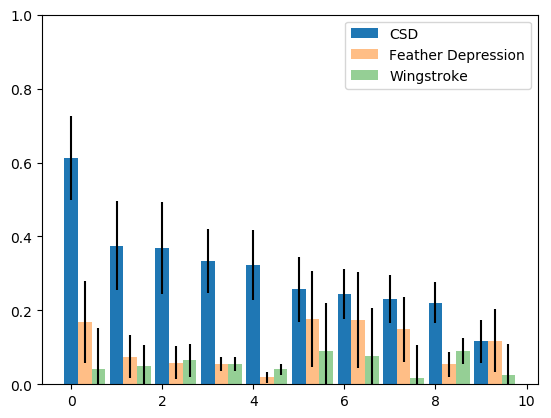

In [668]:
## Plot types of behaviors (Figure 8c)

print(key_behaviors)
print(bird_song_counts.shape) # Behavior, female, song, count, total count
print('n_CSD latencies by bird',np.nansum(bird_song_counts[2,:,:,0],axis=(1)))
print('n_depuff latencies by bird',np.nansum(bird_song_counts[0,:,:,0],axis=(1)))
print('n_wingstroke latencies by bird',np.nansum(bird_song_counts[1,:,:,0],axis=(1)))
depuff_means = np.nanmean(bird_song_counts[0,:,:,0] / bird_song_counts[0,:,:,1],0)
depuff_sem = np.nanstd(bird_song_counts[0,:,:,0] / bird_song_counts[0,:,:,1],0) / np.sqrt(7)

wingstroke_means = np.nanmean(bird_song_counts[1,:,:,0] / bird_song_counts[1,:,:,1],0)
wingstroke_sem = np.nanstd(bird_song_counts[1,:,:,0] / bird_song_counts[1,:,:,1],0) / np.sqrt(5)

print(bird_song_counts[2,5,:])
csd_means = np.nanmean(bird_song_counts[2,:,:,0] / bird_song_counts[2,:,:,1] + .0001,0)
csd_means = np.clip(csd_means,0,1)
csd_sem = np.nanstd(bird_song_counts[2,:,:,0] / bird_song_counts[2,:,:,1],0) / np.sqrt(9)

verified_means = np.nanmean(binary_array3[:,:,:,0],axis=(0,1))
verified_order = np.argsort(verified_means)[::-1]
self_order = np.argsort(csd_means)[::-1]
fig,ax = plt.subplots()
ax.bar(np.arange(10),csd_means[self_order],
       yerr=csd_sem[self_order],alpha=1,width=.3,label='CSD')
ax.bar(np.arange(10)+.3,depuff_means[self_order],
       yerr=depuff_sem[self_order],alpha=.5,width=.3,label='Feather Depression')
ax.bar(np.arange(10)+.6,wingstroke_means[self_order],
       yerr=depuff_sem[self_order],alpha=.5,width=.3,label='Wingstroke')
ax.set_ylim([0,1])
ax.legend()
fig.show()
fig.savefig('./figures/Fig8c.png',dpi=300)


ws_bird_song_ratio = bird_song_counts[0,:,:,0]/bird_song_counts[0,:,:,1]
dp_bird_song_ratio = bird_song_counts[1,:,:,0]/bird_song_counts[1,:,:,1]
csd_bird_song_ratio = bird_song_counts[2,:,:,0]/bird_song_counts[2,:,:,1]

print('CSD:')
print(csd_means,verified_means)
print(f_oneway(*np.transpose(csd_bird_song_ratio[:7])))
print('pearsons r:',pearsonr(csd_means,verified_means))
print('Depuffs')
print(f_oneway(*(np.transpose(dp_bird_song_ratio[:7]))))
print('pearsons r:',pearsonr(depuff_means,csd_means))
print(depuff_means)
#print('baseline r:',pearsonr(depuff_means,np.nanmean(binary_array3[:,:,:,0],axis=(0,1))))
print("Wingstroke")
print(f_oneway(*(np.transpose(ws_bird_song_ratio[:7]))))
print("pearson's r:",pearsonr(wingstroke_means,csd_means))


#ax.scatter(depuff_means,csd_means)

In [46]:
## Some functions to get p-values

def r_to_z(r):
    return np.log((1 + r) / (1 - r)) / 2.0

def z_to_r(z):
    e = np.exp(2 * z)
    return((e - 1) / (e + 1))

def r_confidence_interval(r, alpha, n):
    z = r_to_z(r)
    se = 1.0 / np.sqrt(n - 3)
    z_crit = norm.ppf(1 - alpha/2)  # 2-tailed z critical value

    lo = z - z_crit * se
    hi = z + z_crit * se

    # Return a sequence
    return (z_to_r(lo), z_to_r(hi))

r_confidence_interval(0.159,0.05,10)

(-0.5229823696668093, 0.7168609351301791)

In [638]:
## Stats for different groups:

## R2 has no postures

## Get numbers of songs per bird (or rate per bird...rate per bird)
#print(bird_song_counts[:,0,:,:])
song_rates_by_bird = np.zeros([birdview_meta.n_birds,birdview_meta.n_songs])
for f in range(birdview_meta.n_birds):
    for s in range(birdview_meta.n_songs):
        song_rates_by_bird[f,s] = np.nanmean(birdview_binary[f,:,s,0])
#print(song_rates_by_bird)
song_rates_by_song = np.transpose(song_rates_by_bird[:-1])
#print(song_rates_by_song)
#print(f_oneway(*song_rates_by_song))
for b in range(len(key_behaviors)):
    skipped_birds = 0
    print('-Is there song bias in ',key_behaviors[b],':')
    bird_song_rates = np.empty([birdview_meta.n_birds,birdview_meta.n_songs])
    bird_song_rates.fill(np.nan)
    for f in range(birdview_meta.n_birds):  
        if np.sum(bird_song_counts[b,f,:,0]) <= 1:
            skipped_birds += 1
            continue
        bird_song_rates[f,:] = np.divide(bird_song_counts[b,f,:,0],bird_song_counts[b,f,:,1])
        #print(bird_song_rates[f,:])
    song_rates_list = [list(bird_song_rates[:,s][~np.isnan(bird_song_rates[:,s])]) for s in range(birdview_meta.n_songs)]

    f_stat,p_value = f_oneway(*song_rates_list)
    print('  f_oneway:',np.round(f_stat,3),p_value)
    #print(bird_song_rates,np.nanmean(bird_song_rates,0))
    
    xs = np.nanmean(bird_song_rates,0).flatten()
    ys = np.nanmean(birdview_binary[:,:,:,0],axis=(0,1)).flatten()
    xs_clean = np.copy(xs)[~np.isnan(xs) & ~np.isnan(ys)]
    ys_clean = np.copy(ys)[~np.isnan(xs) & ~np.isnan(ys)]
    r_stat,P_value = pearsonr(xs_clean,ys_clean)

    r_stat,P_value = pearsonr(np.nanmean(birdview_binary[:,:,:,0],axis=(0,1)),np.nanmean(bird_song_rates,0))
    print('  pearsons correlation with potency:',np.round(r_stat,3),P_value)
    print('CI:',r_confidence_interval(r_stat,0.05,len(xs_clean)))
    print(len(xs_clean))
    if False:
        fig,ax = plt.subplots()
        ax.bar(np.arange(10),np.nanmean(bird_song_rates,0)[sorted_order],yerr=np.nanstd(bird_song_rates,0)[sorted_order] / np.sqrt(len(bird_list)))
        ax.set_ylim([0,1])
        ax.set_title(key_behaviors[b])
        fig.show()



-Is there song bias in  Depuff :
  f_oneway: 0.533 0.8448445376586154
  pearsons correlation with potency: 0.446 0.19597035574916508
CI: (-0.25490205286937173, 0.839932696389616)
10
-Is there song bias in  Wingstroke :
  f_oneway: 0.438 0.9059951147318812
  pearsons correlation with potency: 0.293 0.41078974394428125
CI: (-0.41249258979177483, 0.7790630301015875)
10
-Is there song bias in  CSD :
  f_oneway: 1.87 0.07335216923611618
  pearsons correlation with potency: 0.982 4.563704659065303e-07
CI: (0.922864363067061, 0.9958643700310786)
10
-Is there song bias in  Partial CSD :
  f_oneway: 0.497 0.8707541716839449
  pearsons correlation with potency: -0.232 0.5190205186825289
CI: (-0.7517885552463346, 0.4656783386103033)
10


In [637]:
len(song_rates_list)

10

# Supplemental Figures

## Supplemental Figure 1
Additional information on group concordance for song preferences/bias

mean correlation: 0.7183738917994573
[0, 3, 8, 14, 21]


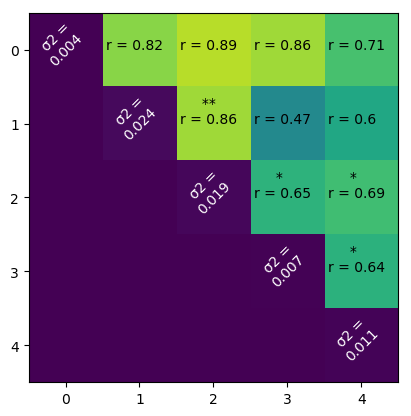

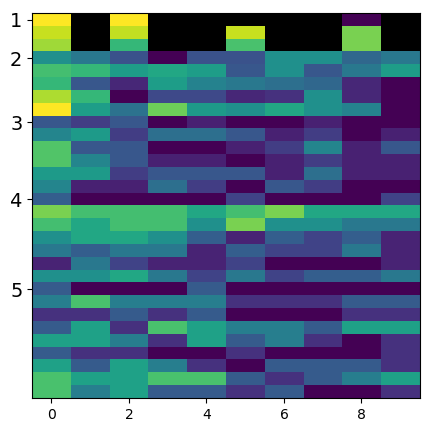

In [80]:
## Calculate Pairwise corr for Supplemental Figure1
same_songs = [0,1,2,5,6]
aviary_rankings = np.zeros([5,10])

## Clean this up, exclude non-responsive birds, correlate even with missing songs for aviary A

bird_song_means = np.empty([0,10])
group_dividers = []
for i in range(len(same_songs)):
    group_dividers.append(len(bird_song_means))
    a = same_songs[i]
    song_list_sorted = sorted(all_metas[a].song_list)
    sorted_song_indices = [all_metas[a].song_dict[s] for s in song_list_sorted]
    #print(sorted_song_indices,np.array(all_metas[a].song_list)[sorted_song_indices])
    binary_dave = all_binary[a][:,:,:,0]
    #binary_dave[binary_dave == 2] = 0
    binary_dave = binary_dave[:,:,sorted_song_indices]
    #print(all_metas[a].song_list,song_list_sorted,sorted_song_indices)
    bird_means = np.nanmean(binary_dave,axis=(1,2))
    #print(bird_means.shape)
    responsive_birds = [bird_means > .05]
    local_rankings = np.nanmean(binary_dave[responsive_birds],axis=(0,1))
    resp_bird_song_means = np.nanmean(binary_dave[responsive_birds],axis=(1))
    bird_song_means =  np.vstack([bird_song_means,resp_bird_song_means])

    #print(local_rankings)
    aviary_rankings[i,:] =local_rankings

#print(aviary_rankings)

pairwise_t = np.zeros([len(same_songs),len(same_songs)])
fig,ax = plt.subplots()
for i in range(len(pairwise_t)):
    for j in range(1,len(pairwise_t)-i):
        k = i+j
        ranks_i = aviary_rankings[i]
        ranks_k = aviary_rankings[k]
        if i == 0:
            ranks_i = aviary_rankings[i][~np.isnan(aviary_rankings[i])]
            ranks_k = aviary_rankings[k][~np.isnan(aviary_rankings[i])]
        r_stat,p_val = pearsonr(ranks_i,ranks_k)
        pairwise_t[i,k] = 1 / p_val
        pairwise_t[i,k] = r_stat
        if verbose:
            print(i,k,pearsonr(ranks_i,ranks_k))
        if p_val < .01:
            sig ='**'
        elif p_val < .05:
            sig = '*'
        else:
            sig=''
            
        #print(i,k,spearmanr(ranks_i,ranks_k))
        #ax.text(k-.35,i,'p = ' + str(np.round(p_val,3)))
        ax.text(k-.45,i,'     ' + sig + '\n' + 'r = ' + str(np.round(r_stat,2)))
print('mean correlation:',np.mean(pairwise_t[pairwise_t > 0]))

if True:
    for i in range(len(pairwise_t)):
        pairwise_t[i,i] = np.var(aviary_rankings[i][~np.isnan(aviary_rankings[i])])
        if verbose:
            print(pairwise_t[i,i])
        ax.text(i-.40,i-.05,' σ2 =\n' + str(np.round(pairwise_t[i,i],3)),color='white',rotation=45)
ax.imshow(pairwise_t,vmax = 1,vmin=0)
fig.show()

fig,ax = plt.subplots()

f_dict['fontweight']='light'
cmap = cm.viridis
cmap.set_bad(color='black')
ax.imshow(bird_song_means[:,np.argsort(np.nanmean(bird_song_means[:],0))[::-1]],aspect='auto',cmap=cmap)
ax.set_yticks(group_dividers)
ax.set_yticklabels(np.arange(5) + 1,fontdict=f_dict)

fig.set_size_inches([5,5])
fig.show()

print(group_dividers)

## Supplementary Figure 2
Lots of additional info on relating shape to potency/response rate

In [49]:
# Grab and vmax for each posture, build df (stats are run in stats_script.py)
# Seq height and vmax are easy enough, and song potency is easy peasy, just build the df, make a plot, done

print(birdview_array.shape)
vmax_list,peak_list = [],[]
stable_list,mean_list = [],[]
r_list,f_list = [],[]
bl_list,s_list,y_list = [],[],[]
pot_list,rpot_list = [],[]
song_potency = np.nanmean(birdview_binary[:,:,:,0],axis=(0,1))
song_potency2018 = np.nanmean(bv2019_binary[:,:,:,0],axis=(0,1))
print(song_potency)
#song_potency = song_potency[np.argsort(song_potency)[::-1]]
#print(song_potency)
print(birdview_meta.song_dict)
print(birdview_meta.bird_dict)
rpot_dict = {}
rpot_list = []

bcor_dict = {
    'CB-LB2':.1,
    'CB-Orange':.3,
    'CB-Y2':.5,
    'CB-Yellow':.7
}

for b in range(len(birdview_meta.bird_list)):
    bird = birdview_meta.bird_list[b]
    rpot_dict[bird] = np.nanmean(birdview_binary[b,:,:,0],axis=0)
for i,row in test_3.iterrows():
    if '2017' in row['SeqName']:
        continue
    try:
        seq = pickle.load(open('./SeqClasses/' + row['SeqName'] + '.obj','rb'))
    except:
        #print('skipping',row['SeqName'])
        continue
    if seq.posture != 1 or seq.offset == 0:
        continue
    if 1 in np.isnan(seq.smooth_data[:,10,2]):
        continue
    if '-' in seq.song or seq.song[0] == 'm':
        continue
    if seq.bird not in birdview_meta.bird_dict.keys():
        continue
    if '2018' in row['SeqName']:
        year = 2018
    elif '2019' in row['SeqName']:
        year = 2019
    else:
        year = 0
    bird_index = birdview_meta.bird_dict[seq.bird]
    block_index = int(seq.block)
    song_index = birdview_meta.song_dict[seq.song]
    response_rate = np.nanmean(birdview_binary[bird_index,block_index,:,0])
    if np.isnan(response_rate) or response_rate == 0:
        print('skpping:',response_rate)
        continue
    r_list.append(response_rate) 
    f_list.append(bird_index)
    bl_list.append(block_index)
    s_list.append(song_index)
    y_list.append(year)
    peak_range = (seq.ts > seq.t_vmax) & (seq.ts < seq.t_refraction)
    mean_list.append(np.nanmean(seq.smooth_data[peak_range,10,2]))
    vmax_list.append(seq.vmax * 1000)
    peak_list.append(seq.peak_height)
    stable_list.append(seq.smooth_data[seq.stable_vel_index,10,2])
    pot_list.append(song_potency[song_index])    
    rpot_list.append(rpot_dict[seq.bird][song_index])

shape_df = pd.DataFrame({'AvgPotency':pot_list,
             'RelPotency':rpot_list,
             'ResponseRate':r_list,
             'MaxVelocity':vmax_list,
             'PeakHeight':peak_list,
             'StableHeight':stable_list,
             'MeanHeight':mean_list,
             'Bird':f_list,
             'Block':bl_list,
             'Song':s_list,
             'Year':y_list})

if False:

    md = smf.mixedlm("StableHeight ~ ResponseRate",data=shape_df,groups=shape_df['Bird'])
    mdf = md.fit()
    print(mdf.summary())

    md = smf.mixedlm("MaxVelocity ~ RelPotency",data=shape_df,groups=shape_df['Bird'])
    mdf1 = md.fit()
    print(mdf1.summary())

    md = smf.mixedlm("MaxVelocity ~ AvgPotency",data=shape_df,groups=shape_df['Bird'])
    mdf2 = md.fit()
    print(mdf2.summary())

    md = smf.mixedlm("MaxVelocity ~ ResponseRate",data=shape_df,groups=shape_df['Bird'])
    mdf3 = md.fit()
    print(mdf3.summary())

if False:
    shape_df.to_csv('shape_df.csv',index=False)

(10, 20, 10, 3)
[0.73333333 0.43478261 0.44897959 0.42028986 0.36       0.15217391
 0.34693878 0.39215686 0.32653061 0.35294118]
{'BDY': 0, 'BOD': 1, 'ND': 2, 'LB': 3, '2M': 4, 'DBR': 5, 'GRG': 6, 'WG': 7, 'LNR': 8, 'DMG': 9}
{'CB-White': 0, 'CB-Orange': 1, 'CB-Yellow': 2, 'CB-Red': 3, 'CB-LB2': 4, 'CB-Y2': 5, 'CB-R2': 6, 'P1': 7, 'Y1': 8, 'PINK2': 9}
skpping: 0.0
skpping: 0.0


F_list): [1 2 3 4 5 7 8 9]
short one, skipping
    AvgPotency  RelPotency  ResponseRate  MaxVelocity  PeakHeight  \
54    0.434783    0.142857           0.2     4.818304    0.091977   
55    0.733333    0.166667           0.2     2.205675    0.059311   

    StableHeight  MeanHeight  Bird  Block  Song  Year  
54      0.090816    0.080671     3      0     1  2019  
55      0.059311    0.052032     3      0     0  2019  
short one, skipping
   AvgPotency  RelPotency  ResponseRate  MaxVelocity  PeakHeight  \
0    0.434783         1.0           1.0     1.122048     0.11725   

   StableHeight  MeanHeight  Bird  Block  Song  Year  
0       0.11725    0.115703     7      0     1  2018  


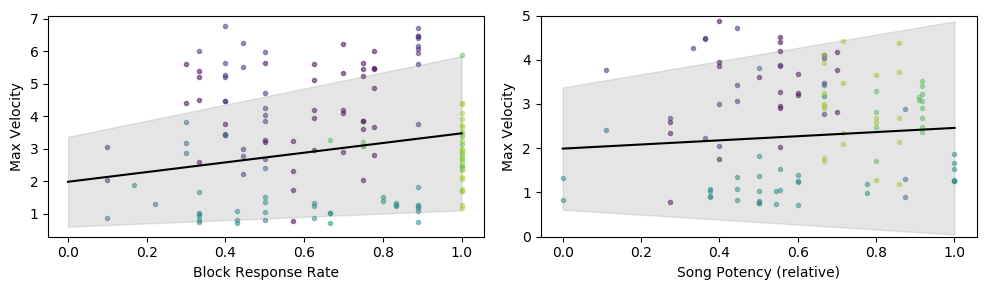

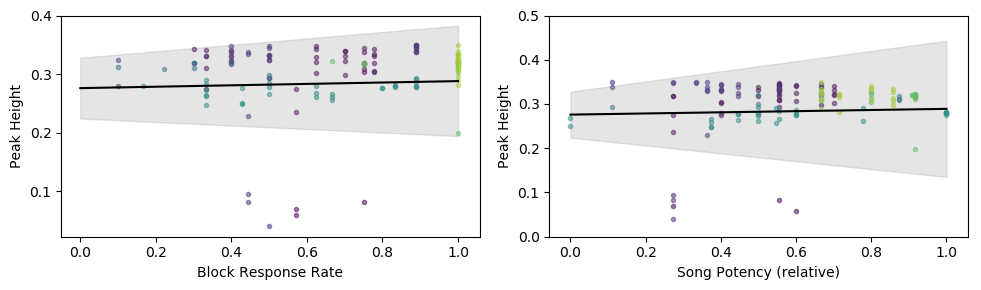

In [50]:
### Plot the stats above for Figure S2a-d

fig,(ax2,ax) = plt.subplots(1,2)

fig2,(ax3,ax1) = plt.subplots(1,2)

e_alpha = .2
print('F_list):',np.unique(f_list))
for f in range(len(np.unique(f_list))):
    
    female = np.unique(f_list)[f]
    female_df = shape_df[shape_df['Bird'] == female]
    if len(female_df) < 5:
        print('short one, skipping')
        print(female_df)
        continue
    vs = female_df['MaxVelocity']
    rs = female_df['ResponseRate']
    ps = female_df['PeakHeight']
    ss = female_df['RelPotency']
    
    ## Plot velocity vs potency
    ax.scatter(ss,vs,marker='.',alpha=.5,color=cm.viridis(f / len(np.unique(f_list))))
    fit_line = np.poly1d(np.polyfit(ss,vs,1))
    #ax.plot([0,1],fit_line([0,1]),color=cm.viridis(f / len(np.unique(f_list))),linestyle=':')
    ax.set_xlabel('Song Potency (relative)')
    ax.set_ylabel('Max Velocity')
    
    ## Plot peak vs potency
    ax1.scatter(ss,ps,marker='.',alpha=.5,color=cm.viridis(f / len(np.unique(f_list))))
    fit_line = np.poly1d(np.polyfit(ss,ps,1))
    #ax1.plot([0,1],fit_line([0,1]),color=cm.viridis(f / len(np.unique(f_list))),linestyle=':')
    ax1.set_xlabel('Song Potency (relative)')
    ax1.set_ylabel('Peak Height')
    
    ## Plot velocity vs response rate
    ax2.scatter(rs,vs,marker='.',alpha=.5,color=cm.viridis(f / len(np.unique(f_list))))
    fit_line = np.poly1d(np.polyfit(rs,vs,1))
    #ax2.plot([0,1],fit_line([0,1]),color=cm.viridis(f / len(np.unique(f_list))),linestyle=':')
    ax2.set_xlabel('Block Response Rate')
    ax2.set_ylabel('Max Velocity')
    
    ## Plot peak vs response rate
    ax3.scatter(rs,ps,marker='.',alpha=.5,color=cm.viridis(f / len(np.unique(f_list))))
    fit_line = np.poly1d(np.polyfit(rs,ps,1))
    #ax3.plot([0,1],fit_line([0,1]),color=cm.viridis(f / len(np.unique(f_list))),linestyle=':')
    ax3.set_xlabel('Block Response Rate')
    ax3.set_ylabel('Peak Height')



# VMAX
intercept = 1.991
int_low,int_high = [0.610,3.373]

##vmax:potency
effect = 0.468
eff_low,eff_high = [-0.559,1.495]
"""intercept,effect,_ = mdf.params
int_low,int_high = [0.002,0.006]
eff_low,eff_high = [-0.001,0.001]"""

fit_line = np.poly1d([effect,intercept])
low_line = np.poly1d([eff_low,int_low])
high_line = np.poly1d([eff_high,int_high])

ax.plot([0,1],fit_line([0,1]),color='black')
ax.fill_between([0,1],high_line([0,1]),low_line([0,1]),color='gray',alpha=e_alpha)

#vmax_rate
"""intercept,effect,_ = mdf2.params
int_low,int_high = [0.002,0.005]
eff_low,eff_high = [0.001,0.002]"""
effect = 1.490
eff_low,eff_high = [0.501,2.480]

fit_line = np.poly1d([effect,intercept])
low_line = np.poly1d([eff_low,int_low])
high_line = np.poly1d([eff_high,int_high])

ax2.plot([0,1],fit_line([0,1]),color='black')
ax2.fill_between([0,1],high_line([0,1]),low_line([0,1]),color='gray',alpha=e_alpha)

## Height (rel or avg potency?)
#intercept = 0.198
#int_low,int_high = [0.124,0.271]
intercept = 0.276
int_low,int_high = [0.224,0.328]
# height: avg_pot
effect = 0.013
eff_low,eff_high = -0.089,0.115

"""intercept,effect,_ = mdf1.params
int_low,int_high = [0.232,0.317]
eff_low,eff_high = [-0.008,0.104]"""

fit_line = np.poly1d([effect,intercept])
low_line = np.poly1d([eff_low,int_low])
high_line = np.poly1d([eff_high,int_high])

ax1.plot([0,1],fit_line([0,1]),color='black')
ax1.fill_between([0,1],high_line([0,1]),low_line([0,1]),color='gray',alpha=e_alpha)

#height_rate
effect = 0.012
eff_low,eff_high = -0.030,0.055
"""intercept,effect,_ = mdf3.params
int_low,int_high = [0.266,0.330]
eff_low,eff_high = [-0.036,0.050]"""

fit_line = np.poly1d([effect,intercept])
low_line = np.poly1d([eff_low,int_low])
high_line = np.poly1d([eff_high,int_high])

ax3.plot([0,1],fit_line([0,1]),color='black')
ax3.fill_between([0,1],high_line([0,1]),low_line([0,1]),color='gray',alpha=e_alpha)


ax.set_ylim([0,5])
ax1.set_ylim([0,.5])

fig.set_size_inches([10,3])
fig2.set_size_inches([10,3])
fig.tight_layout()
fig2.tight_layout()
fig.show()
fig2.show()

# The Code for Figure S2e-f and Figure S3 is in a second notebook:
## SupplementalAnalysis.ipynb


## Suuplemental Video: Make Methods Video

Just some code to generate images, the actual processing happens elsewhere

In [ ]:
seq_name = './SeqClasses/2019-05-30-07-07-56_GRG.obj'

seq = pickle.load(open(seq_name,'rb'))
print(seq.t_refraction)

In [ ]:
## Make 3d images
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

EC = np.mean(seq.smooth_data[:,[4,12]],1)
SC = np.mean(seq.smooth_data[:,[5,13]],1)
bones = [
    [0,4],  #beak-left eye
    [0,12], #beak-right eye
    [4,12], #right eye-left eye
    [20,21],#eye-center shoulder-center
    [21,7], #shoulder-center left-wrist
    [21,15],#shoulder-center right-wrist
    [21,1], #should-center keel
    [1,2],  #keel-tailbone
    [21,2], #should-center tailbone
    [15,16],#right-wrist right-wingtip
    [7,8],  #left-wrist left-wingtip
    [2,9],  #tailbone left-knee
    [9,10], #left-knee left-ankle
    [2,17], #tailbone right-knee
    [17,18],#right-knee right-ankle
    [10,11],#left-ankle left-heel
    [18,19],#right-ankle right-heel
    [2,3]   #tailbone tail-tip
    ]

bone_colors = ['brown','brown','brown','black',
               'blue','blue','green','green','green','blue','blue',
              'red','red','red','red','red','red','purple']

for t in range(len(seq.ts)):
    ax.scatter(seq.smooth_data[t,:,0],seq.smooth_data[t,:,1],seq.smooth_data[t,:,2])
    full_data = np.empty([len(seq.smooth_data),22,3])
    full_data[:,:20] = seq.smooth_data
    full_data[:,20] = EC
    full_data[:,21] = SC

    for n in range(len(bones)):
        b = bones[n]
        ax.plot(full_data[t,b,0],full_data[t,b,1],full_data[t,b,2],color=bone_colors[n])
    ax.set_xlim([0,.4])
    ax.set_ylim([0,.4])
    ax.set_zlim([0,.4])
    fig.set_size_inches(7,7)
    fig.savefig('./tmp/3d_figs/' + f'{t:04}' + '.png',dpi=300)
    ax.clear()


In [ ]:
## Make and plot images
%matplotlib inline

fig,ax = plt.subplots()
ax.set_xlim([seq.ts[0],seq.ts[-1]])
ax.set_ylim([0,.4])


for t in range(len(seq.smooth_data)):
    ax.plot(seq.ts[0:t],seq.smooth_data[0:t,3,2])
    ax.scatter(seq.ts[t],seq.smooth_data[t,3,2],s=40,color='blue')
    ## Plot lines
    if t > seq.tzero_index[0]:
        ax.axvline(seq.tzero,color='gray')
        if t > seq.t_latency_index:
            ax.axvline(seq.t_latency,color='orange')
            if t > seq.vmax_index[0]:
                ax.axvline(seq.t_vmax,color='red')
                if t > seq.stable_vel_index:
                    ax.axvline(seq.t_stable_vel,color='purple')
                    if t > seq.refraction_index[0]:
                        ax.axvline(seq.t_refraction,color='green')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Tail Height (m)')
    ax.set_xlim([seq.ts[0],seq.ts[-1]])
    ax.set_ylim([0,.4])
    
    fig.set_size_inches(7,7)
    fig.savefig('./tmp/test_figs/' + f'{t:04}' + '.png',dpi=300)
    ax.clear()